Visualizing inputs, outputs, kernels and hidden layer activations of a ConvLSTM->Conv network

In [2]:
%load_ext autoreload
%autoreload 2
import sys
sys.path.append('../..')
import os
import numpy as np
import pandas as pd
from datetime import datetime, timedelta
from sklearn import preprocessing
import netCDF4 as nc
import torch
from torch import nn, utils
from torch.utils.tensorboard import SummaryWriter
from src import load_data, evaluate, conv_lstm, datasets, visualize
import torch.autograd as autograd
import pickle
import matplotlib.pyplot as plt
import torchvision as tv

time_stamp = datetime.now().strftime('%Y%m%d-%H%M%S')
time_stamp

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


'20190815-123639'

In [3]:
import logging
logger = logging.getLogger()
fhandler = logging.FileHandler(filename='../log.out', mode='a')
chandler = logging.StreamHandler(sys.stdout)
formatter = logging.Formatter('%(asctime)s - {} - %(message)s'.format(time_stamp))
fhandler.setFormatter(formatter)
chandler.setFormatter(formatter)
logger.addHandler(fhandler)
logger.addHandler(chandler)
logger.setLevel(logging.INFO)

In [4]:
USE_CUDA = False
if torch.cuda.is_available():
    print('CUDA Available')
    USE_CUDA = True
device = torch.device('cuda:0' if USE_CUDA else 'cpu')
num_devices = torch.cuda.device_count() if USE_CUDA else 0
logger.warning('cuda devices: {}'.format(list(torch.cuda.get_device_name(i) for i in range(num_devices))))
torch.manual_seed(0)
np.random.seed(0)

2019-08-15 12:36:42,579 - 20190815-123639 - cuda devices: []


In [5]:
batch_size = 32
seq_len = 5*24
seq_steps = 2
stateful_lstm = False
validation_fraction, val_start, val_end = None, None, None

train_start = datetime.strptime('2010-01-01', '%Y-%m-%d') + timedelta(hours=seq_len * seq_steps)  # first day for which to make a prediction in train set
train_end = '2012-12-31'
test_start = '2013-01-01'
test_end = '2014-12-31'

In [6]:
rdrs_vars = list(range(8))
train_dataset = datasets.RdrsGridDataset(rdrs_vars, seq_len, seq_steps, train_start, train_end)
test_dataset = datasets.RdrsGridDataset(rdrs_vars, seq_len, seq_steps, test_start, test_end, conv_scalers=train_dataset.conv_scalers)

In [7]:
rdrs_data, rdrs_varnames, _ = load_data.load_rdrs_forcings(as_grid=True)
rdrs_varnames = np.array(rdrs_varnames)[rdrs_vars]

In [8]:
landcover_types = None
landcover, landcover_legend = load_data.load_landcover_reduced(values_to_use=landcover_types)
landcover = torch.from_numpy(landcover).float()

../../src/load_data.py:402: UserWarning: WARNING: valid_range not used since it
cannot be safely cast to variable data type
  landcover_fullres = np.array(landcover_nc['Band1'][:])[::-1,:]


In [9]:
rdrs_mask = visualize.get_mask_from_rdrs()

In [10]:
class ConvLSTMGridWithGeophysicalInput(nn.Module):
    def __init__(self, input_size, input_dim, geophysical_dim, convlstm_hidden_dim, conv_hidden_dim, convlstm_kernel_size, conv_kernel_size, num_convlstm_layers, num_conv_layers, conv_activation, dropout=0.0):
        super(ConvLSTMGridWithGeophysicalInput, self).__init__()
        self.conv_lstm = ConvLSTM((input_size[0], input_size[1]), input_dim, convlstm_hidden_dim, convlstm_kernel_size, num_convlstm_layers, batch_first=True)
        self.dropout = nn.Dropout2d(p=dropout)
        if num_conv_layers == 1:
            pad = conv_kernel_size[0][0] // 2, conv_kernel_size[0][1] // 2
            self.conv_out = nn.Conv2d(convlstm_hidden_dim[-1] + geophysical_dim, 1, conv_kernel_size[0], padding=pad)
        else:
            pad = conv_kernel_size[0][0] // 2, conv_kernel_size[0][1] // 2
            conv_layers = [nn.BatchNorm2d(convlstm_hidden_dim[-1] + geophysical_dim), 
                           nn.Conv2d(convlstm_hidden_dim[-1] + geophysical_dim, conv_hidden_dim[0], conv_kernel_size[0], padding=pad),
                           nn.Dropout(p=dropout), conv_activation()]
            for i in range(1, num_conv_layers - 2):
                pad = conv_kernel_size[i][0] // 2, conv_kernel_size[i][1] // 2
                conv_layers.append(nn.BatchNorm2d(conv_hidden_dim[i-1]))
                conv_layers.append(nn.Conv2d(conv_hidden_dim[i-1], conv_hidden_dim[i], conv_kernel_size[i], padding=pad))
                conv_layers.append(conv_activation())
                conv_layers.append(nn.Dropout2d(p=dropout))
            pad = conv_kernel_size[-1][0] // 2, conv_kernel_size[-1][1] // 2
            conv_layers.append(nn.BatchNorm2d(conv_hidden_dim[-1]))
            conv_layers.append(nn.Conv2d(conv_hidden_dim[-1], 1, conv_kernel_size[-1], padding=pad))
            self.conv_out = nn.Sequential(*conv_layers)
        
    def forward(self, input_tensor, geophysics_tensor, hidden_state=None):
        convlstm_out, hidden = self.conv_lstm(input_tensor, hidden_state=hidden_state)
        convlstm_out = self.dropout(convlstm_out[-1][:,-1,:,:,:])  # last output of last layer
        conv_in = torch.cat([convlstm_out, geophysics_tensor], dim=1)
        return self.conv_out(conv_in)[:,0,:,:], hidden

In [11]:
model = torch.load('../../pickle/models/ConvLSTM_withLandcover_allStations_20190725-124949.pkl', map_location='cpu').module
model.eval()

/home/mgauch/miniconda3/envs/gwf/lib/python3.7/site-packages/torch/serialization.py:453: SourceChangeWarning: source code of class 'torch.nn.parallel.data_parallel.DataParallel' has changed. you can retrieve the original source code by accessing the object's source attribute or set `torch.nn.Module.dump_patches = True` and use the patch tool to revert the changes.
  warnings.warn(msg, SourceChangeWarning)
/home/mgauch/miniconda3/envs/gwf/lib/python3.7/site-packages/torch/serialization.py:453: SourceChangeWarning: source code of class 'src.conv_lstm.ConvLSTM' has changed. you can retrieve the original source code by accessing the object's source attribute or set `torch.nn.Module.dump_patches = True` and use the patch tool to revert the changes.
  warnings.warn(msg, SourceChangeWarning)
/home/mgauch/miniconda3/envs/gwf/lib/python3.7/site-packages/torch/serialization.py:453: SourceChangeWarning: source code of class 'src.conv_lstm.ConvLSTMCell' has changed. you can retrieve the original s

ConvLSTMGridWithGeophysicalInput(
  (conv_lstm): ConvLSTM(
    (cell_list): ModuleList(
      (0): ConvLSTMCell(
        (conv): Conv2d(16, 32, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
      )
      (1): Identity()
      (2): ConvLSTMCell(
        (conv): Conv2d(16, 32, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
      )
      (3): Identity()
    )
  )
  (dropout): Dropout2d(p=0.2, inplace=False)
  (conv_out): Sequential(
    (0): BatchNorm2d(27, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (1): Conv2d(27, 4, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (2): Dropout(p=0.2, inplace=False)
    (3): Sigmoid()
    (4): BatchNorm2d(4, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): Conv2d(4, 1, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  )
)

In [12]:
if stateful_lstm:
    test_sampler = datasets.StatefulBatchSampler(test_dataset, batch_size)
    test_dataloader = torch.utils.data.DataLoader(test_dataset, batch_sampler=test_sampler, pin_memory=True)
else:
    test_dataloader = torch.utils.data.DataLoader(test_dataset, batch_size, shuffle=False, pin_memory=True, drop_last=False)

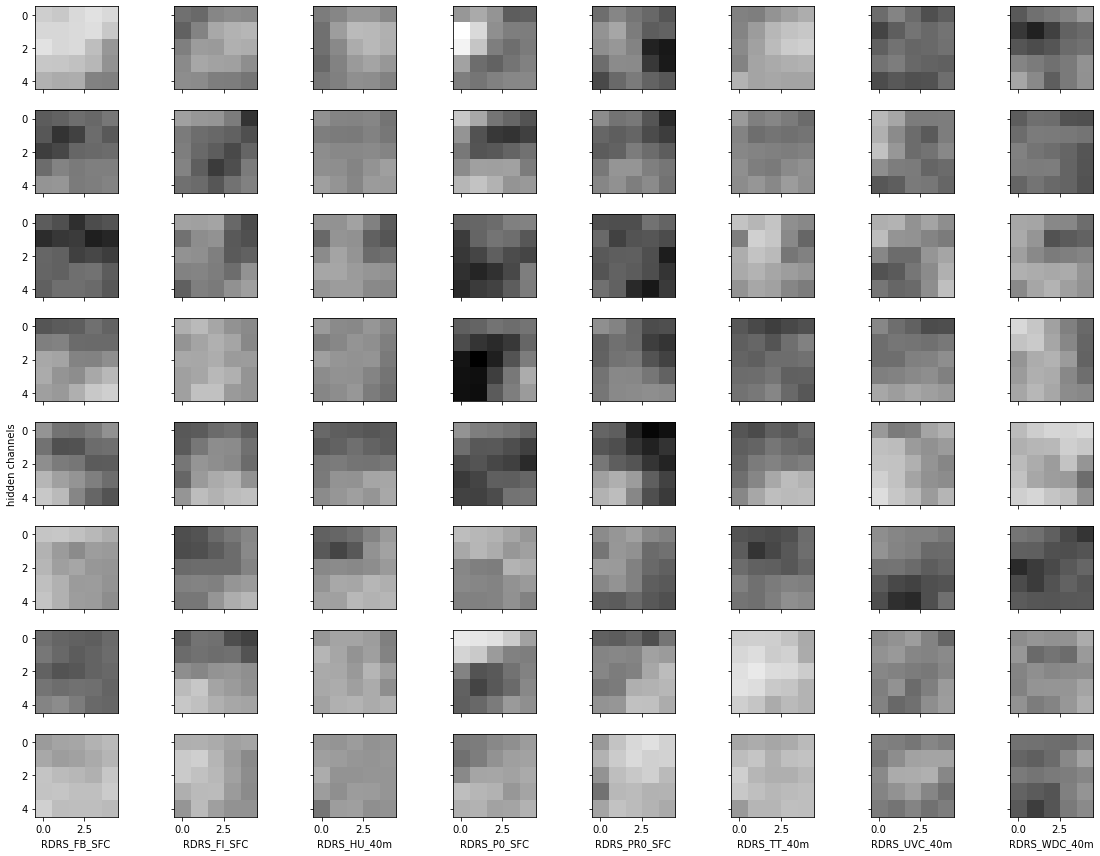

In [13]:
# Visualize kernels input -> 1st hidden layer
convlstm_conv = model.conv_lstm.cell_list[0].conv
visualize.visualize_kernels(convlstm_conv, rdrs_varnames, convlstm_conv.weight.shape[0] // 4)

In [14]:
in_data = test_dataloader.__iter__().next()
x_conv, y, mask = in_data['x_conv'], in_data['y'], in_data['mask']
out, _ = model(x_conv, landcover.repeat(y.shape[0],1,1,1), hidden_state=None)
out = out.detach()

In [15]:
sample = 0 # which sample of the batch to look at

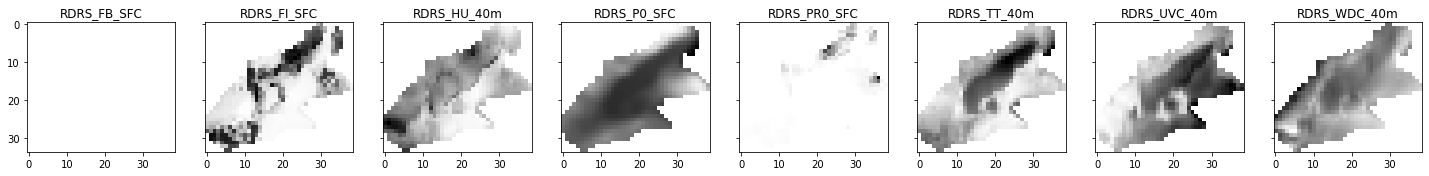

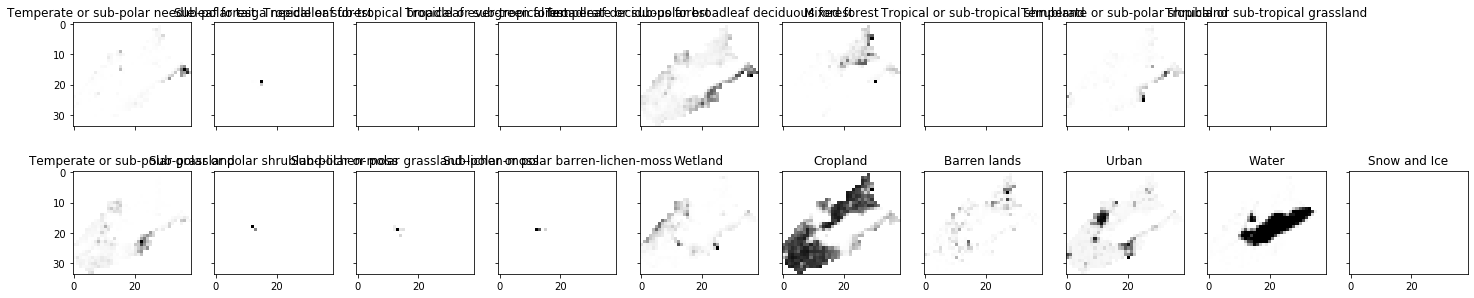

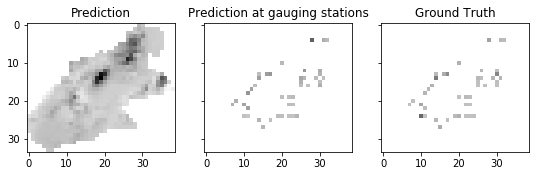

In [16]:
# Visualize input and predictions
f, ax = plt.subplots(1,len(rdrs_varnames), sharex=True, sharey=True, figsize=(25,9))
for i in range(len(rdrs_varnames)):
    ax[i].imshow(np.ma.masked_where(rdrs_mask,x_conv[sample,-1,i]), cmap='Greys')
    ax[i].set_title(rdrs_varnames[i])

f, ax = plt.subplots(2,len(landcover_legend)//2+1, sharex=True, sharey=True, figsize=(25,5))
for i in range(len(landcover_legend)//2):
    ax[0,i].imshow(np.ma.masked_where(rdrs_mask, landcover[i]), cmap='Greys')
    ax[0,i].set_title(landcover_legend[i])
for i in range(len(landcover_legend)//2, len(landcover_legend)):
    ax[1,i-len(landcover_legend)//2].imshow(np.ma.masked_where(rdrs_mask, landcover[i]), cmap='Greys')
    ax[1,i-len(landcover_legend)//2].set_title(landcover_legend[i])
_ = list(f.delaxes(ax[0,i]) for i in range(len(landcover_legend)//2,ax.shape[1]))
_ = list(f.delaxes(ax[1,i]) for i in range(len(landcover_legend)-len(landcover_legend)//2,ax.shape[1]))

f, ax = plt.subplots(1,3, sharex=True, sharey=True, figsize=(9,6))
cropped_out = np.ma.masked_where(rdrs_mask, out[sample])
ax[0].imshow(cropped_out, cmap='Greys', vmin=cropped_out.min(), vmax=cropped_out.max())
ax[1].imshow(np.ma.masked_where(~mask[sample],out[sample]), cmap='Greys', vmin=out[sample].min(), vmax=out[sample].max())
ax[2].imshow(np.ma.masked_where(~mask[sample],y[sample]), cmap='Greys', vmin=out[sample].min(), vmax=out[sample].max())
_ = ax[0].set_title('Prediction')
_ = ax[1].set_title('Prediction at gauging stations')
_ = ax[2].set_title('Ground Truth')

/home/mgauch/miniconda3/envs/gwf/lib/python3.7/site-packages/ipykernel_launcher.py:3: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  This is separate from the ipykernel package so we can avoid doing imports until


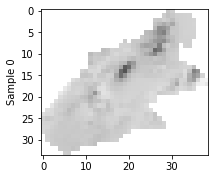

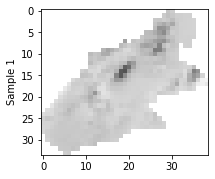

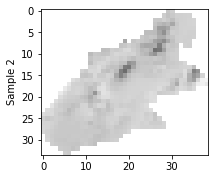

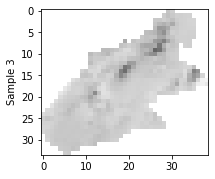

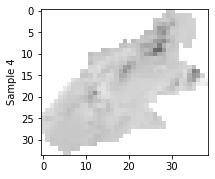

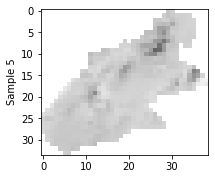

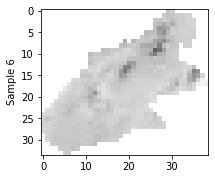

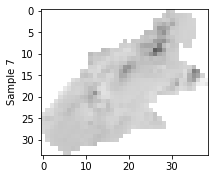

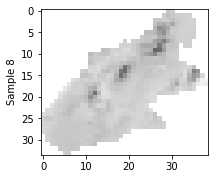

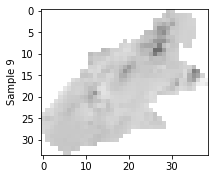

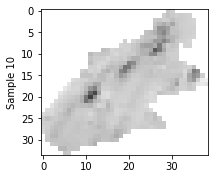

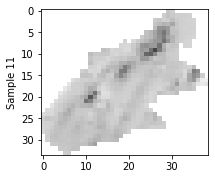

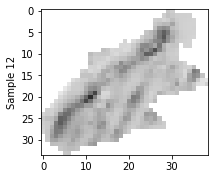

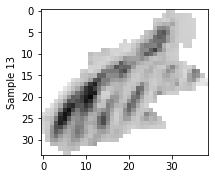

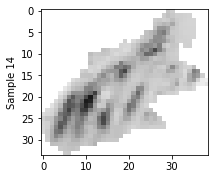

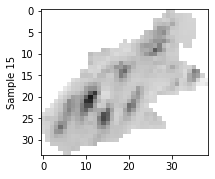

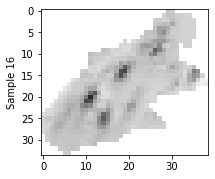

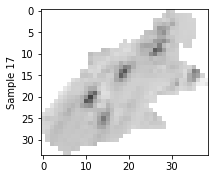

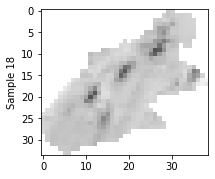

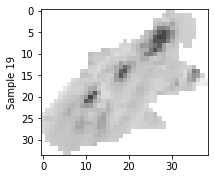

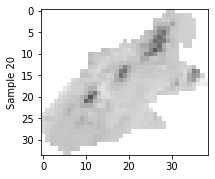

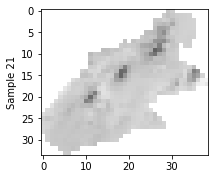

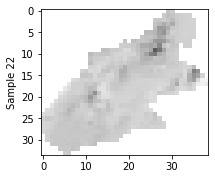

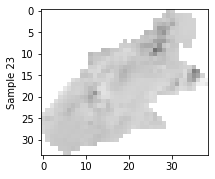

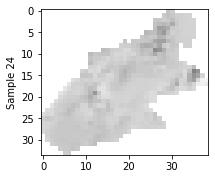

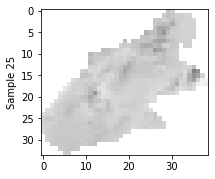

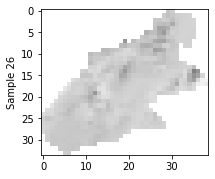

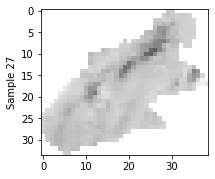

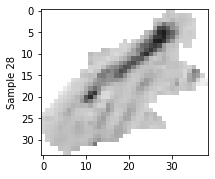

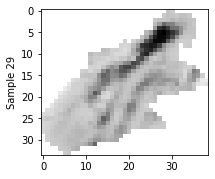

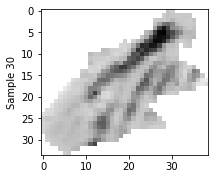

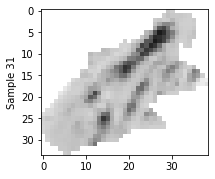

In [17]:
# Visualize predictions over time
for sample in range(batch_size):
    f = plt.figure(figsize=(3,3))
    plt.ylabel('Sample {}'.format(sample))
    plt.imshow(np.ma.masked_where(rdrs_mask,out[sample]), cmap='Greys', vmin=out.min(), vmax=out.max())

/home/mgauch/miniconda3/envs/gwf/lib/python3.7/site-packages/ipykernel_launcher.py:3: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  This is separate from the ipykernel package so we can avoid doing imports until


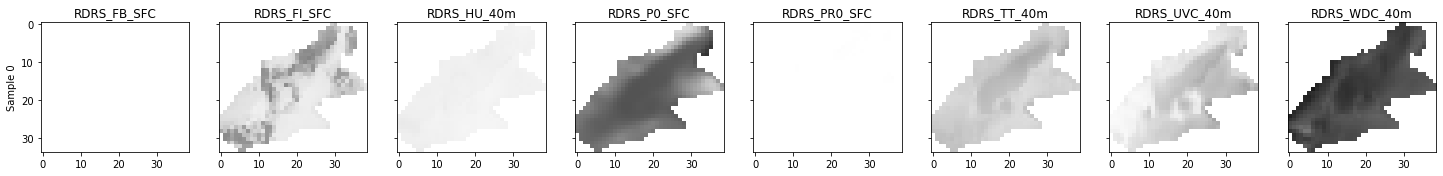

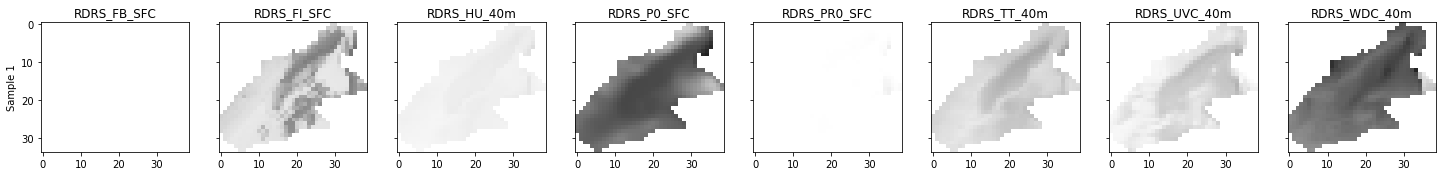

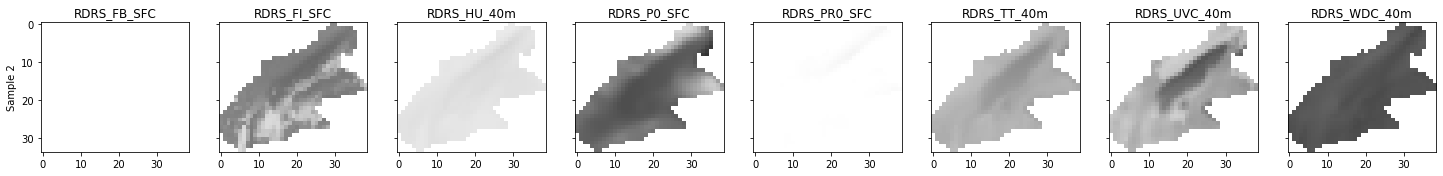

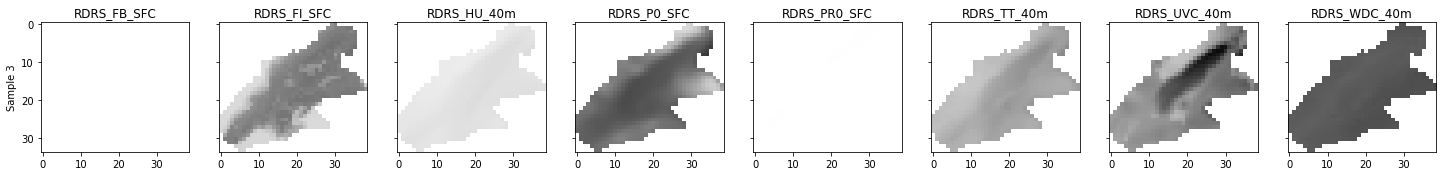

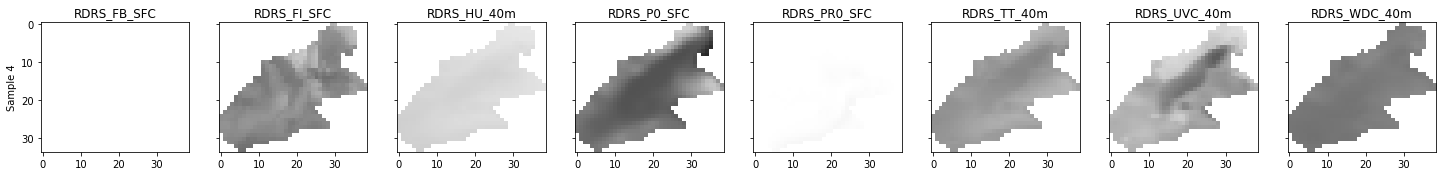

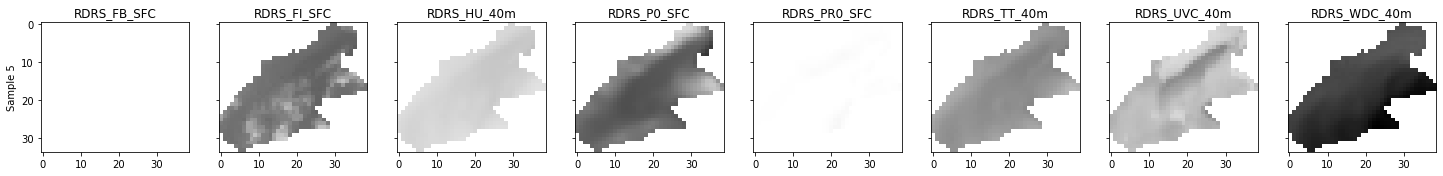

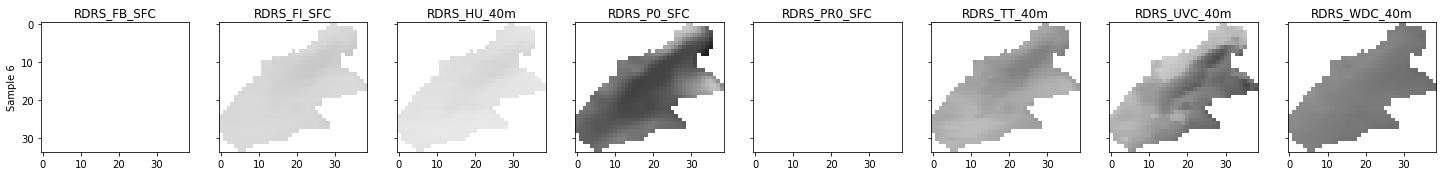

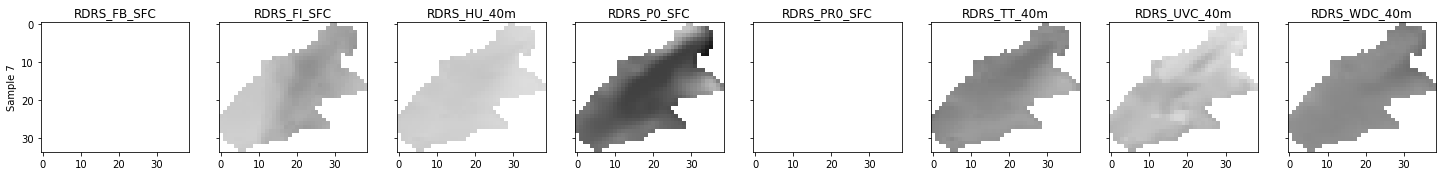

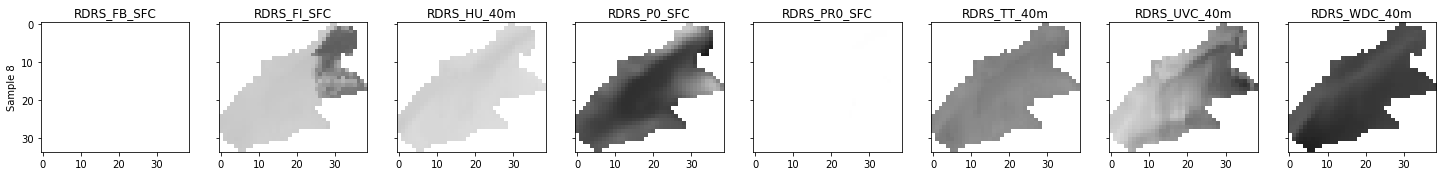

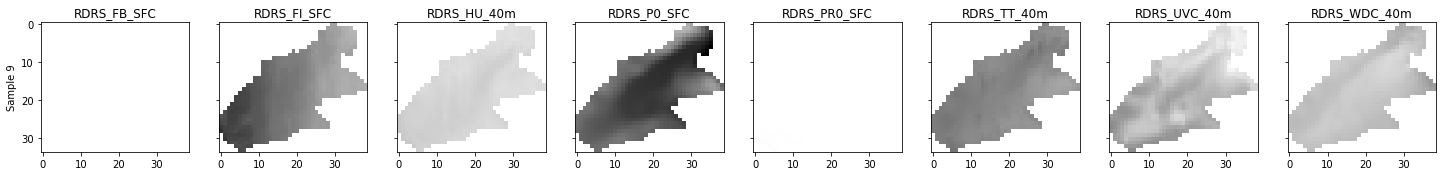

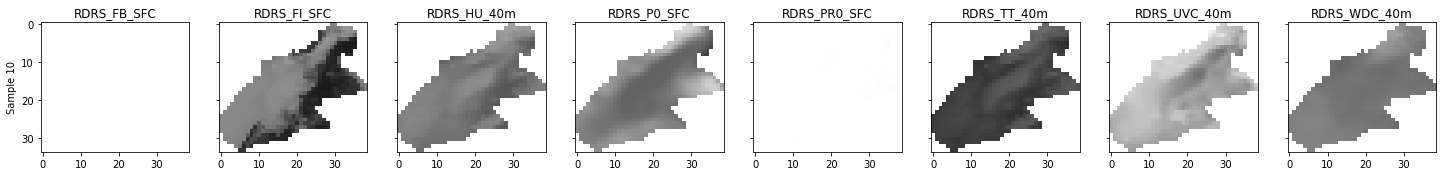

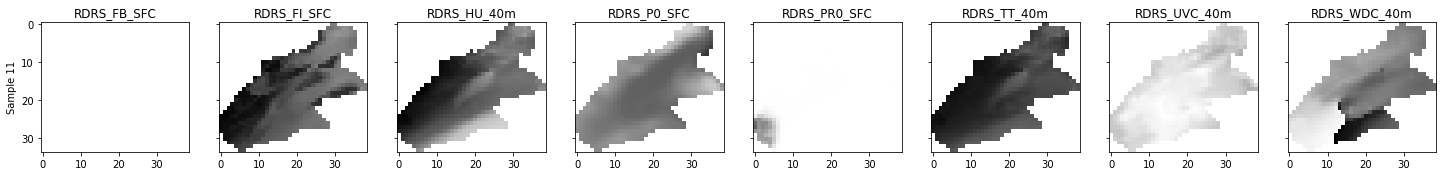

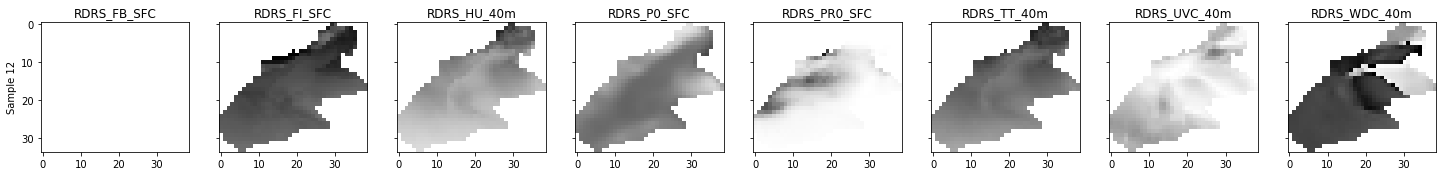

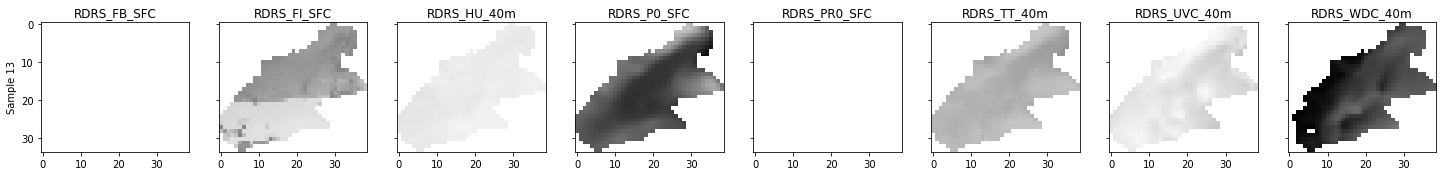

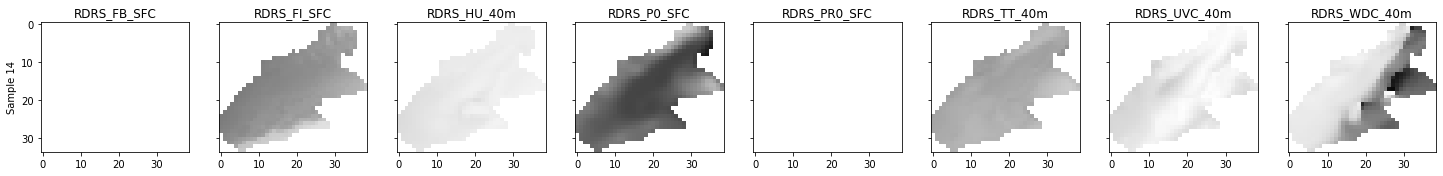

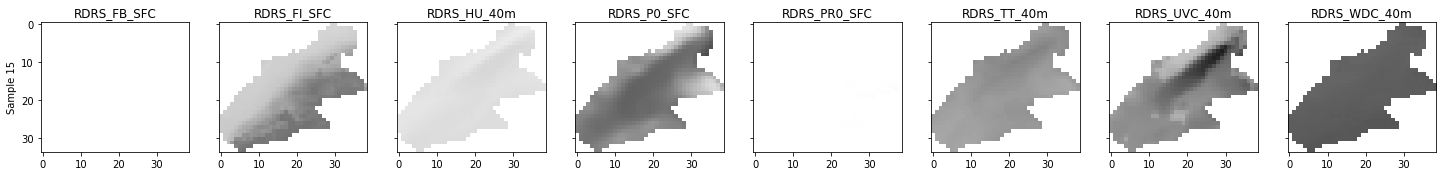

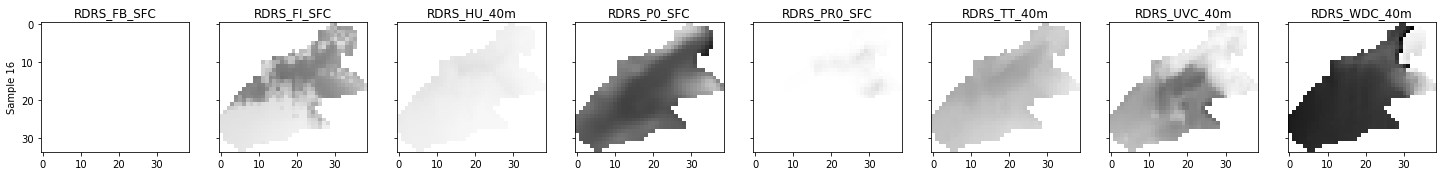

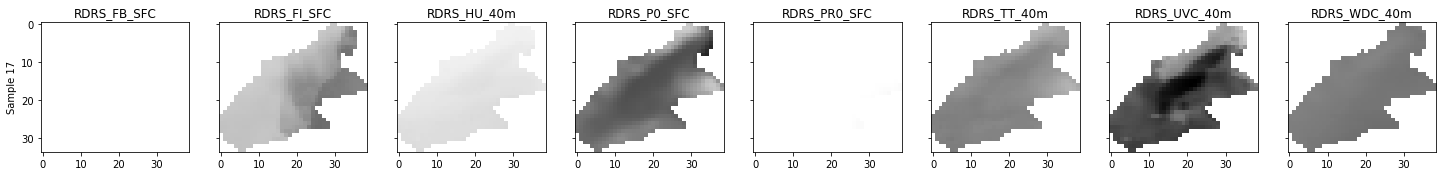

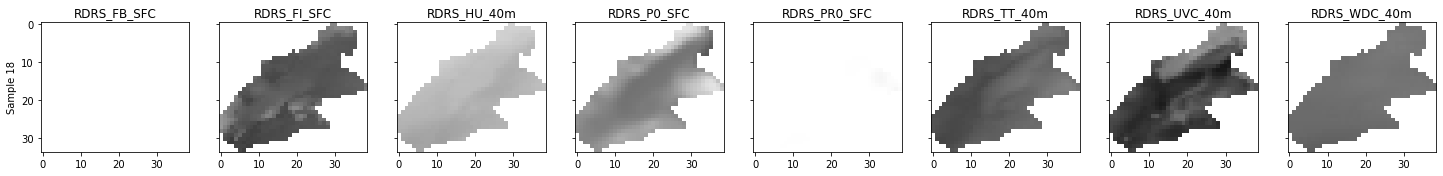

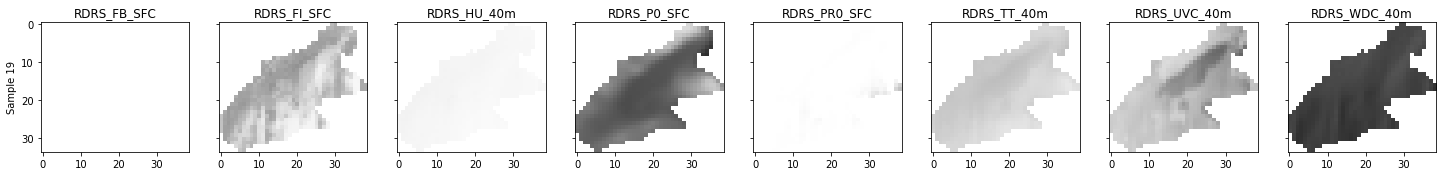

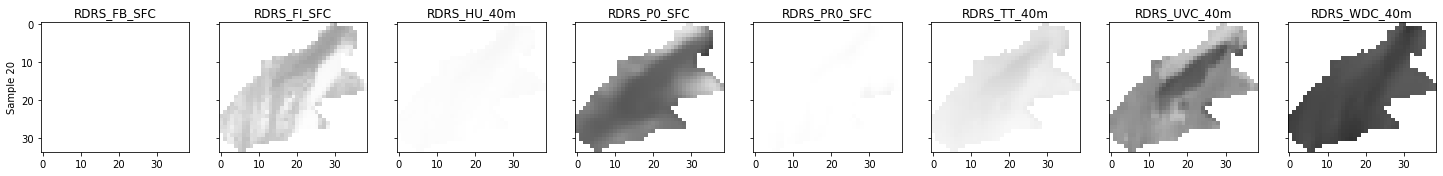

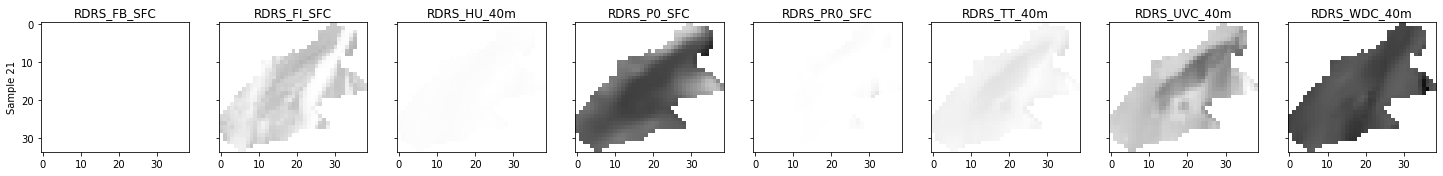

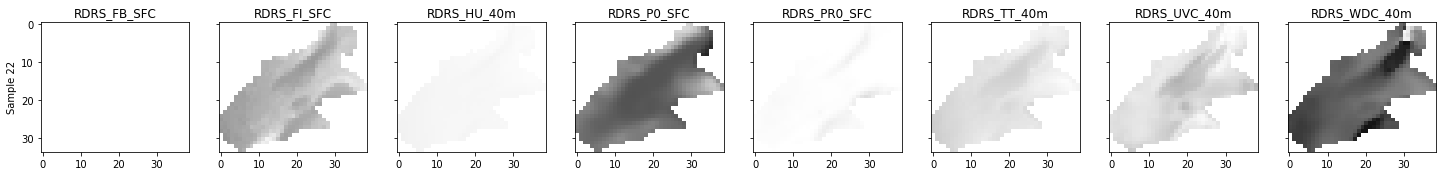

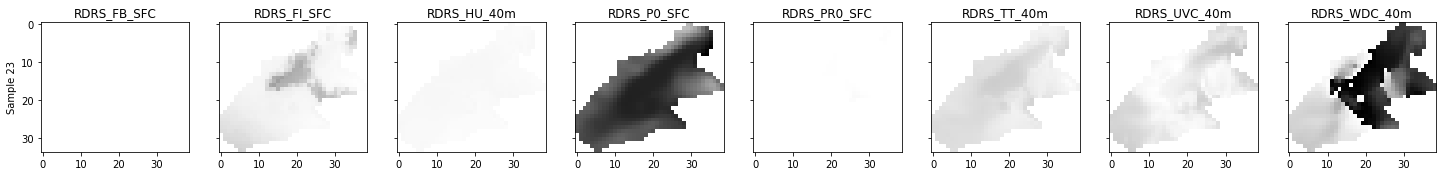

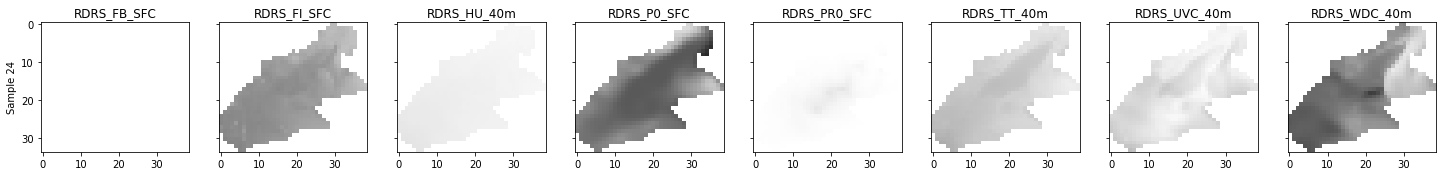

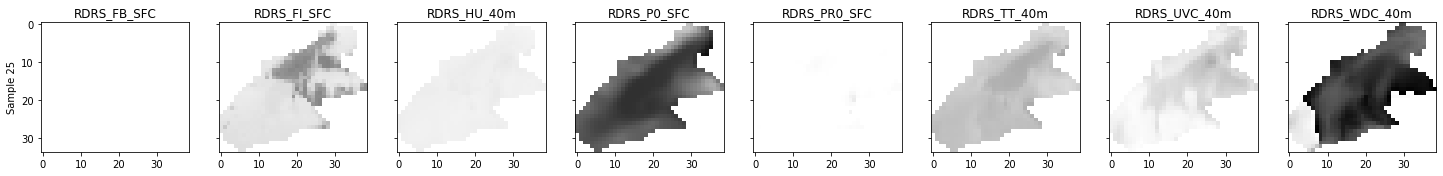

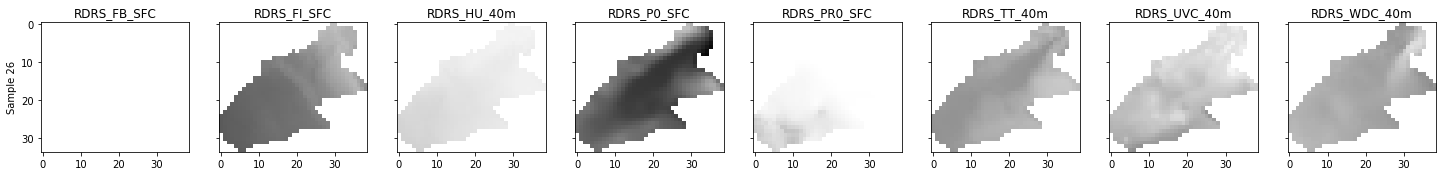

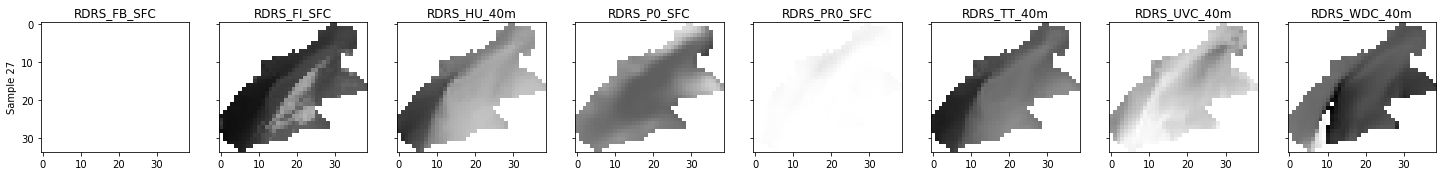

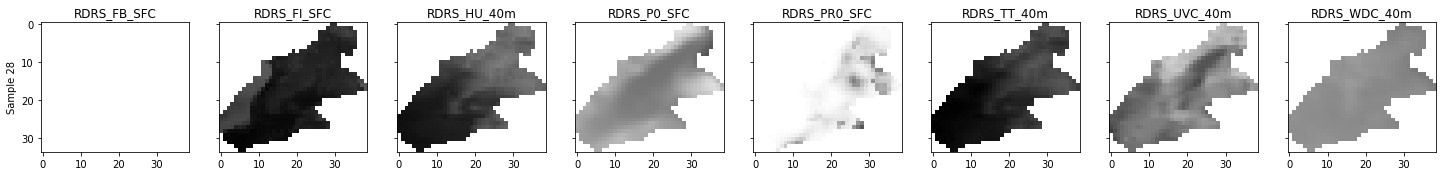

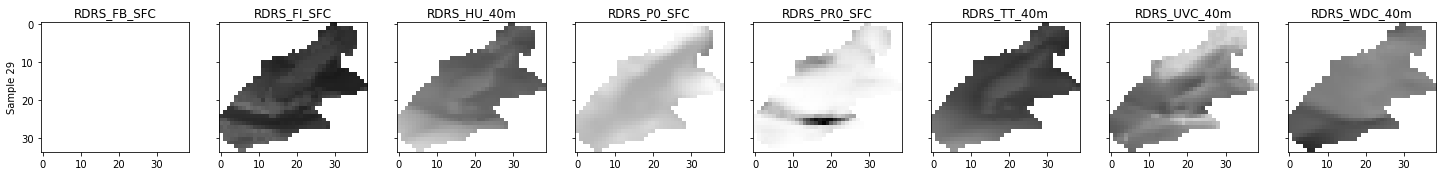

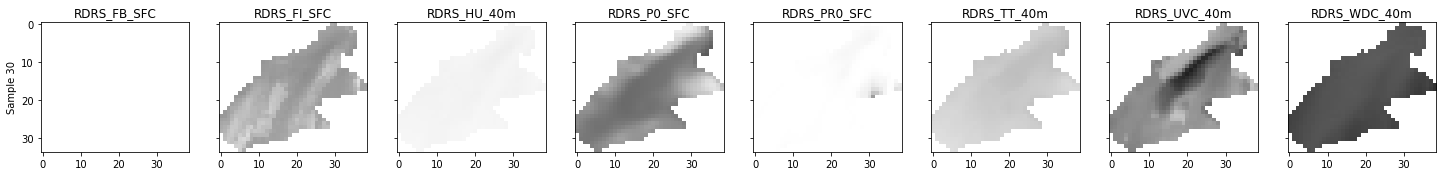

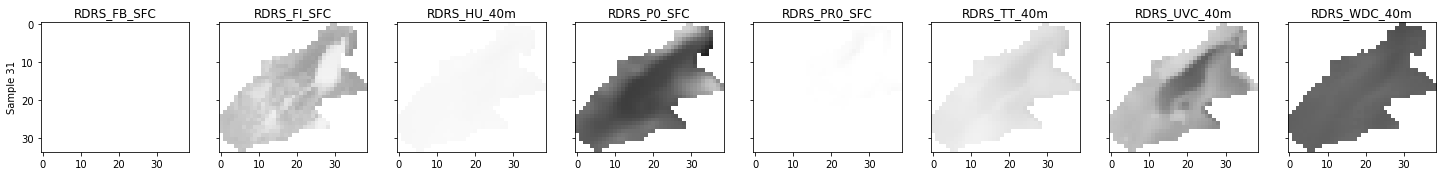

In [18]:
# Visualize input over time
for sample in range(batch_size):
    f, ax = plt.subplots(1,len(rdrs_varnames), sharex=True, sharey=True, figsize=(25,3))
    for i in range(len(rdrs_varnames)):
        vmin,vmax=np.ma.masked_where(np.tile(rdrs_mask, (x_conv.shape[0],1,1)), x_conv[:,-1,i]).min(), np.ma.masked_where(np.tile(rdrs_mask, (x_conv.shape[0],1,1)), x_conv[:,-1,i]).max()
        ax[i].imshow(np.ma.masked_where(rdrs_mask, x_conv[sample,-1,i]), cmap='Greys',vmin=vmin,vmax=vmax)
        ax[i].set_title(rdrs_varnames[i])
    ax[0].set_ylabel('Sample {}'.format(sample))

In [19]:
model.conv_lstm.return_all_layers = True
convlstm_layers_out, _ = model.conv_lstm(x_conv)

../../src/visualize.py:49: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  f, ax = plt.subplots(len(hidden_layers), max_channels, sharex=True, sharey=True, figsize=figsize)


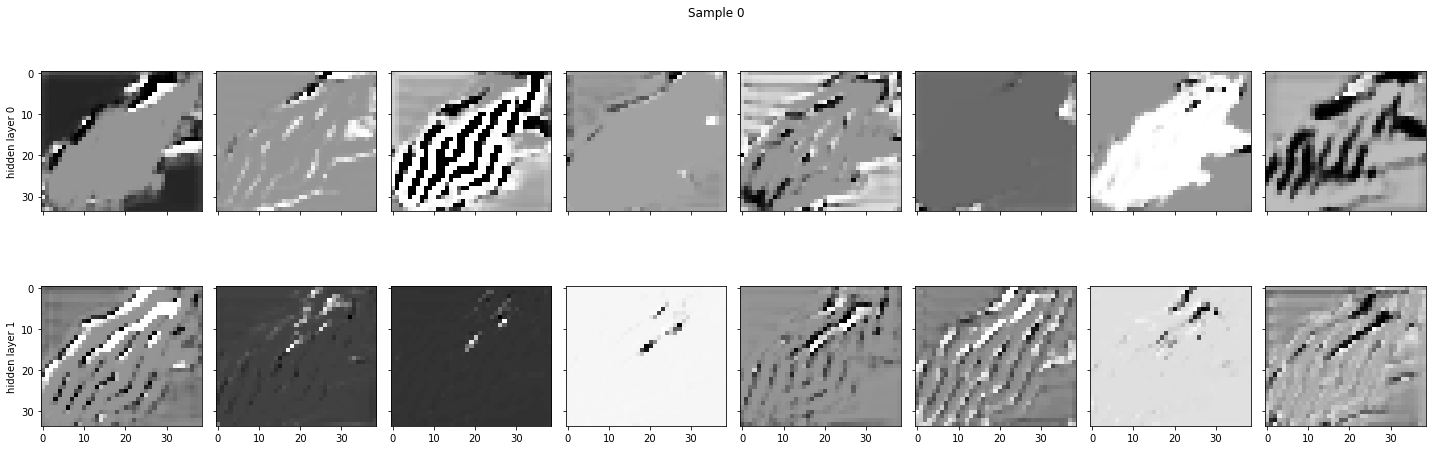

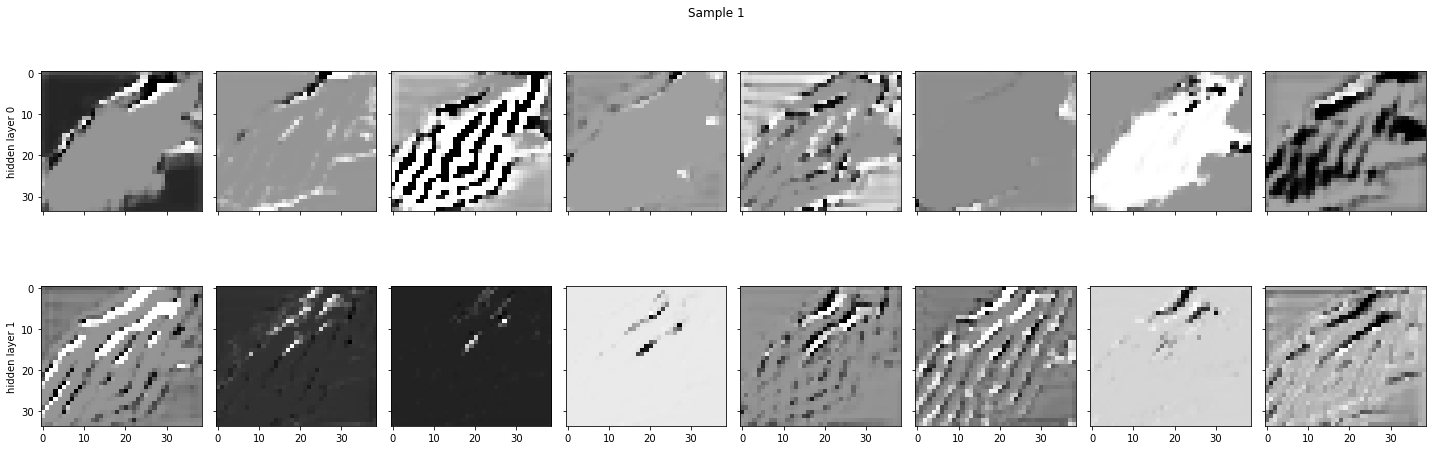

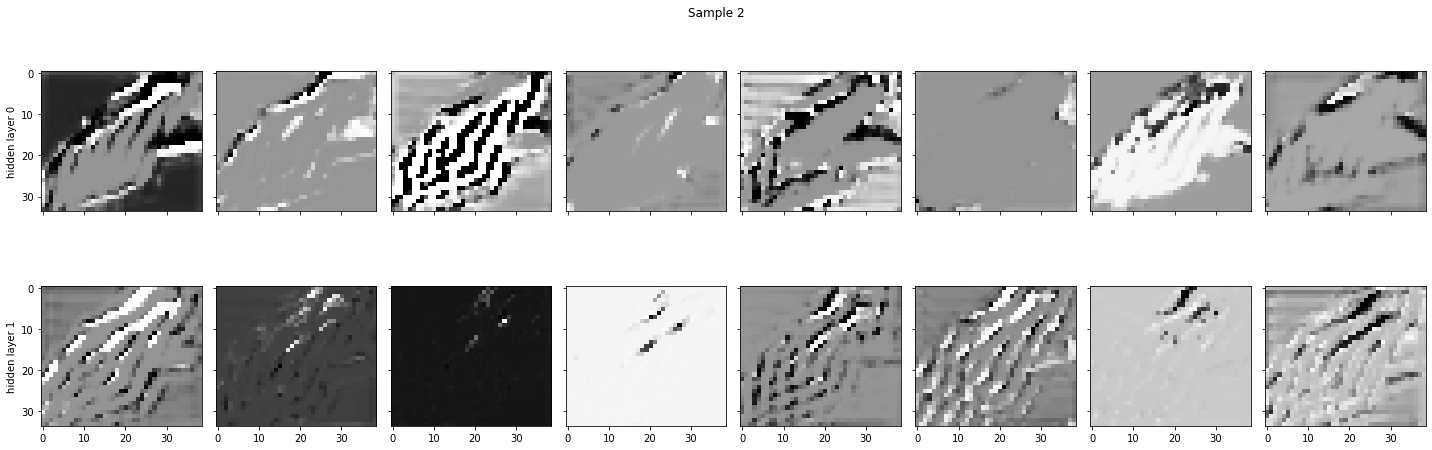

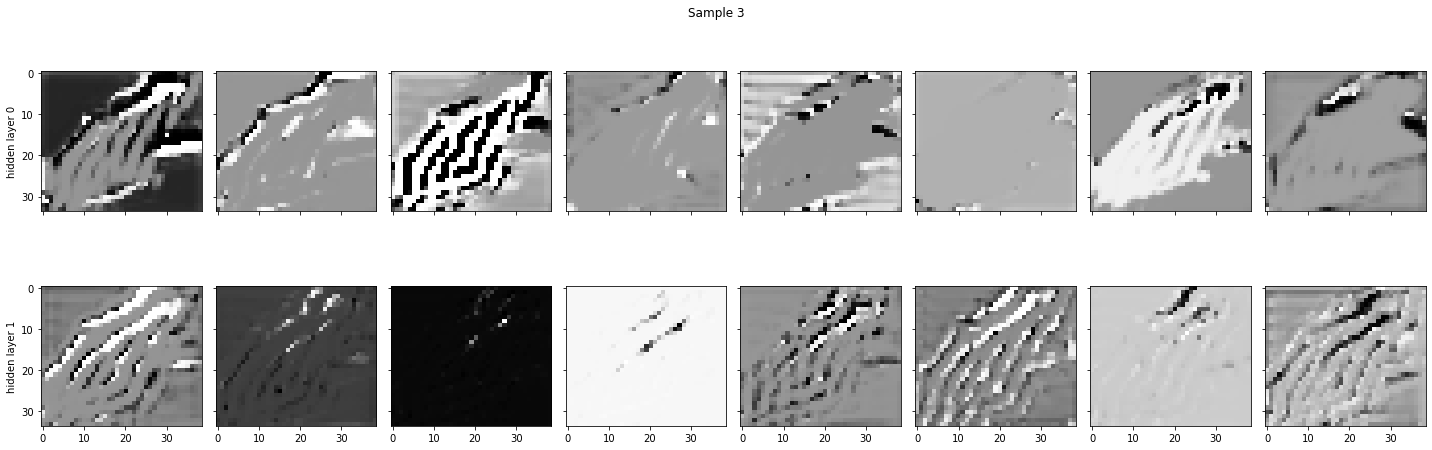

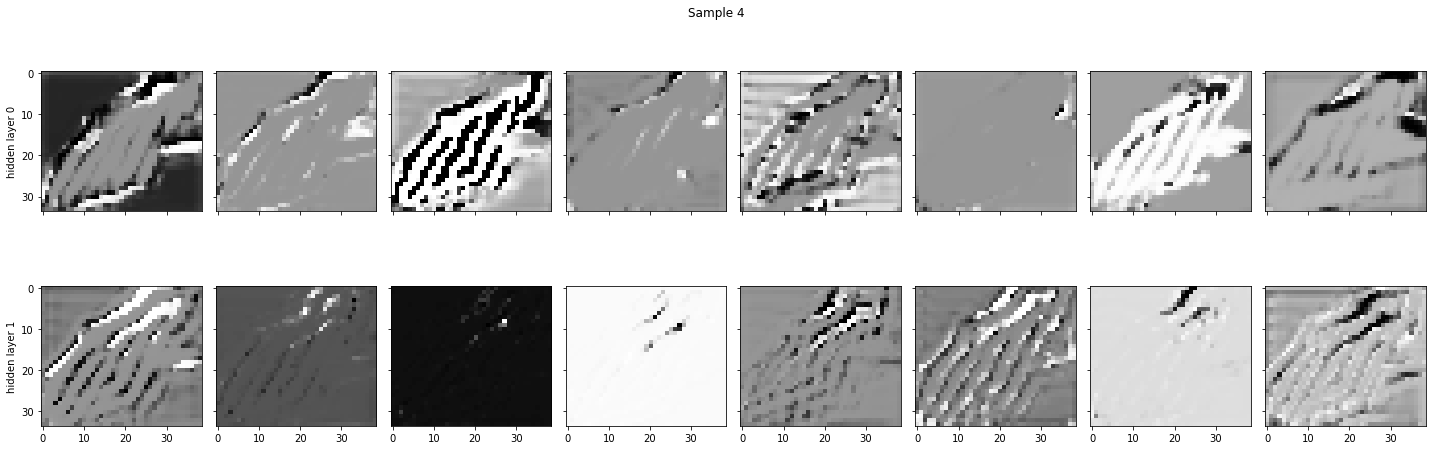

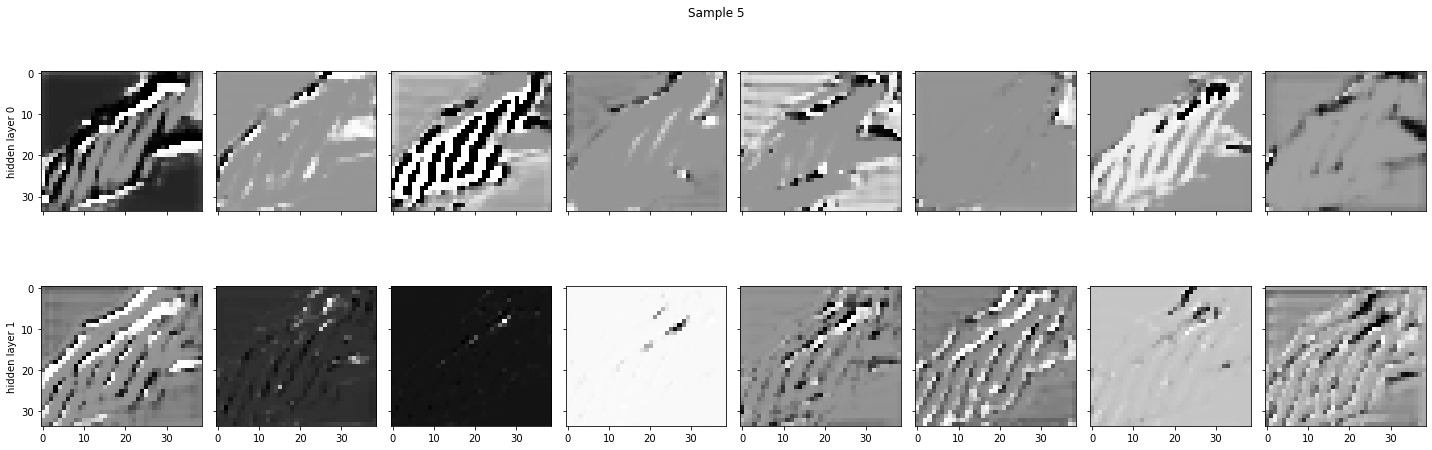

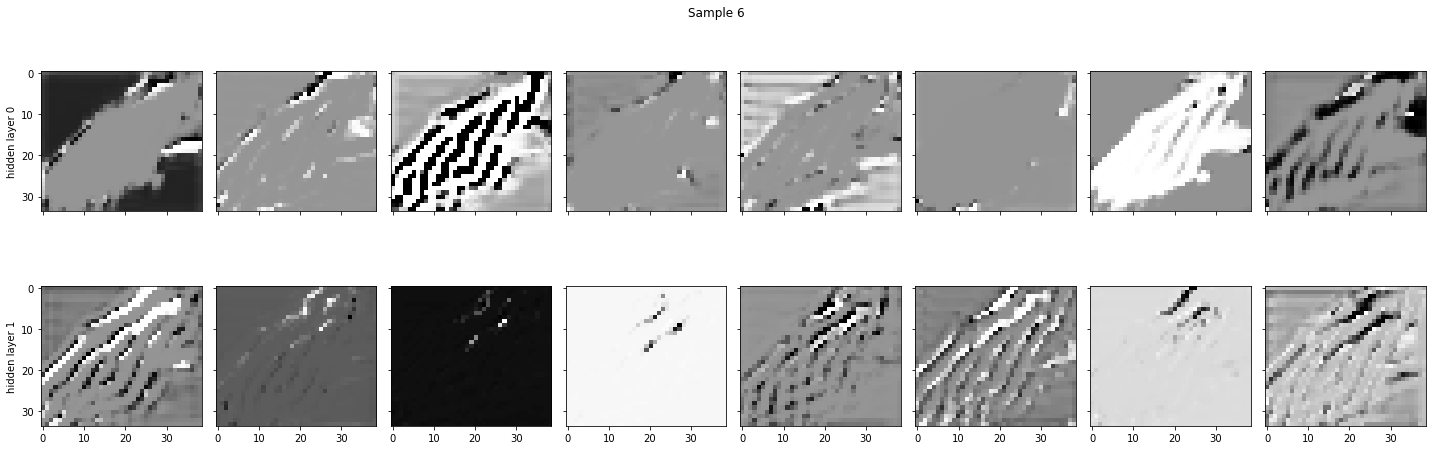

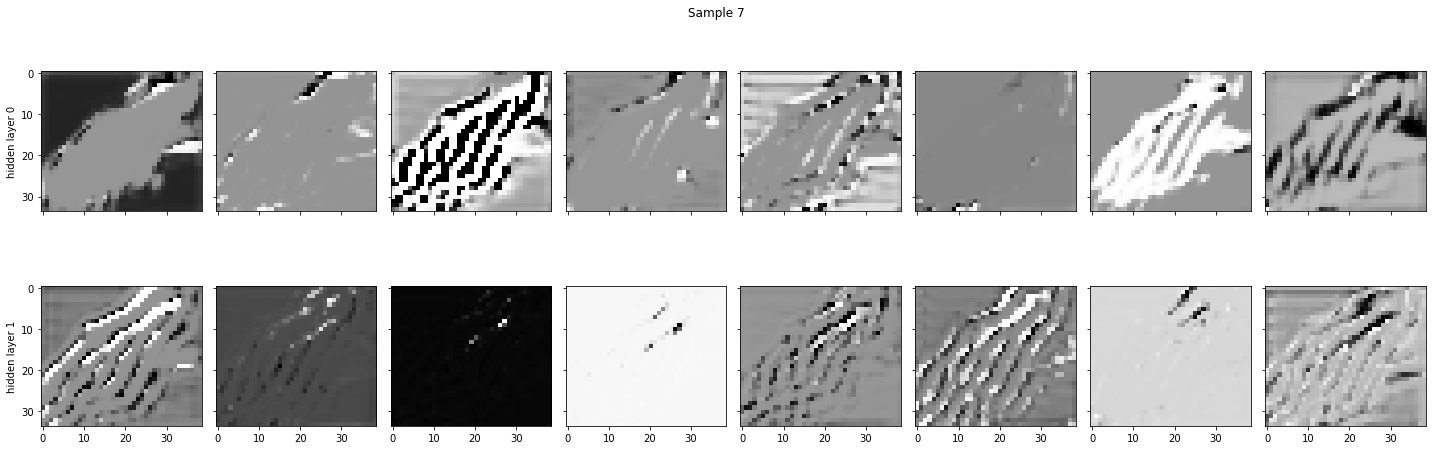

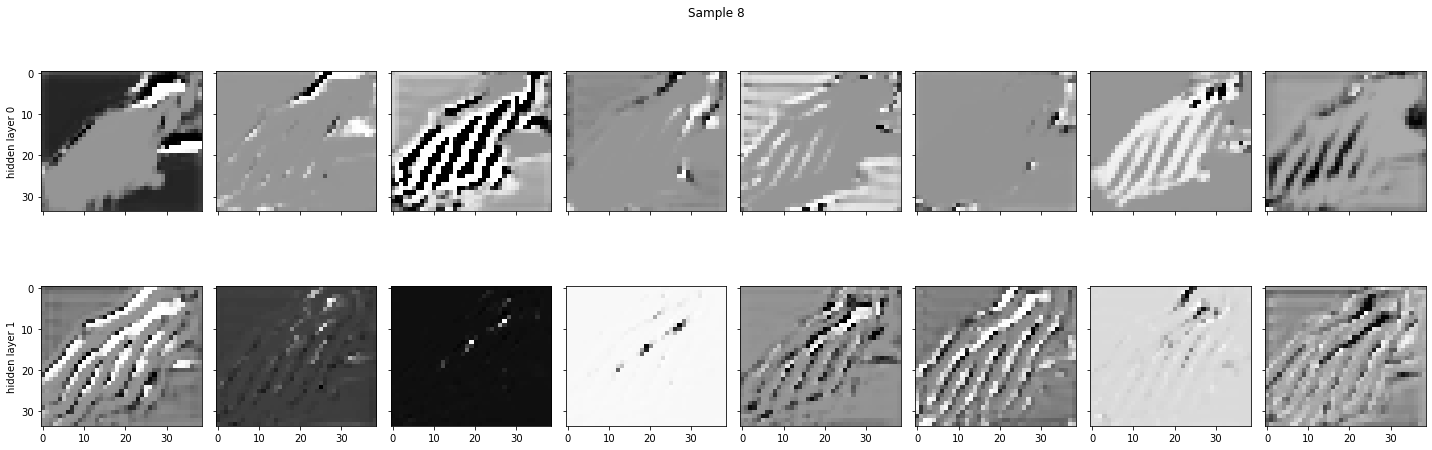

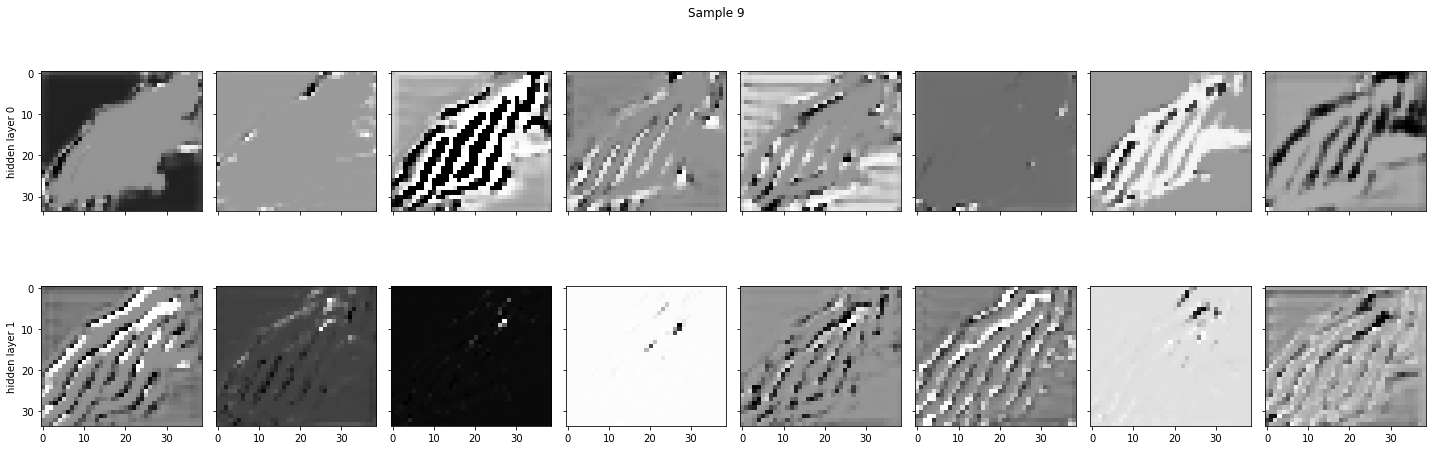

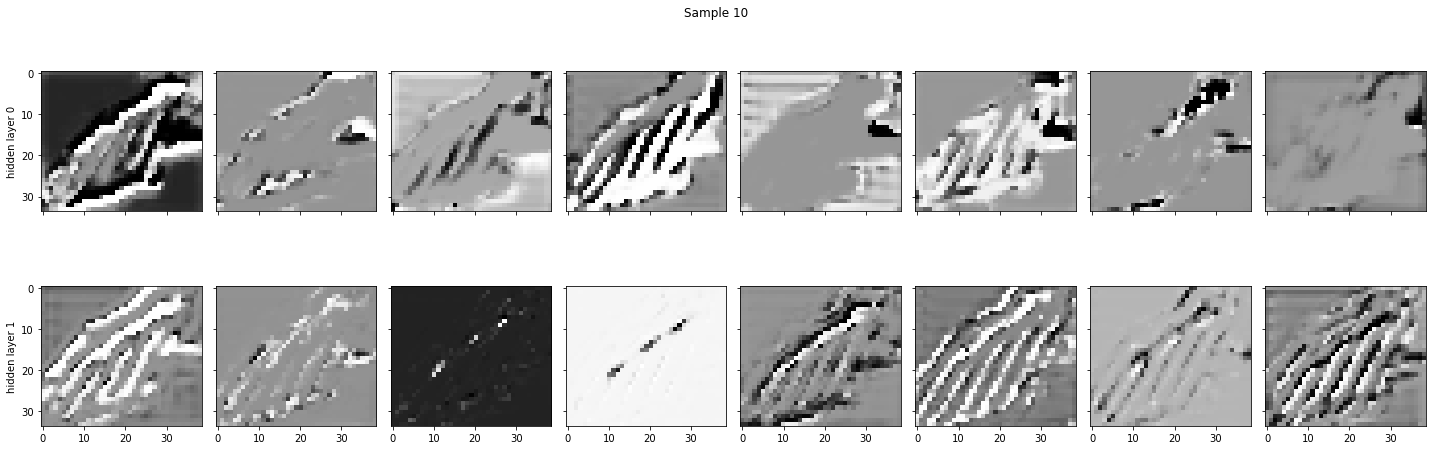

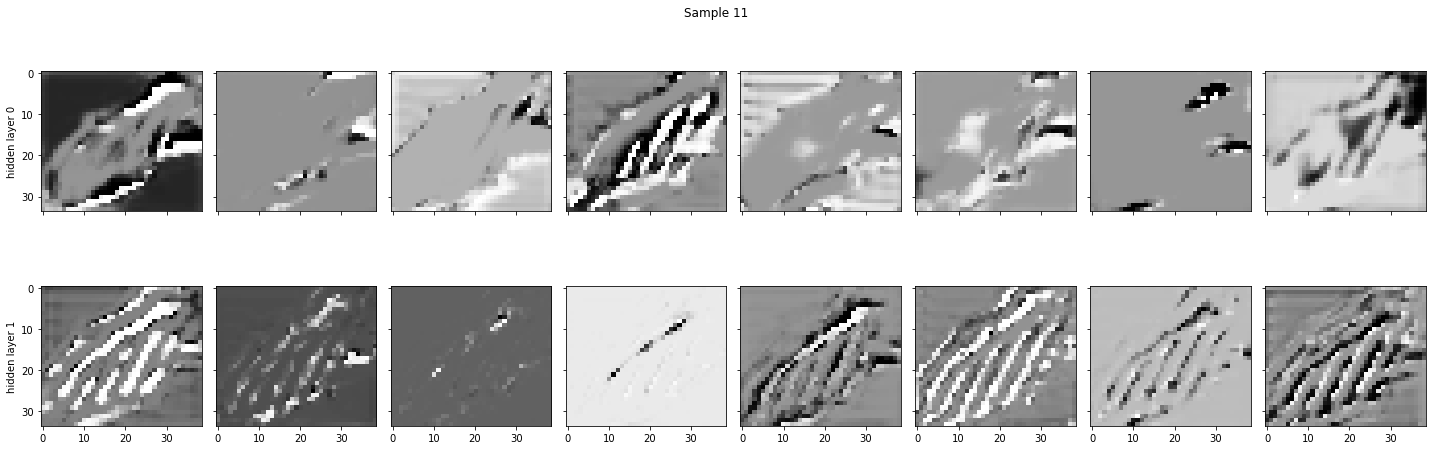

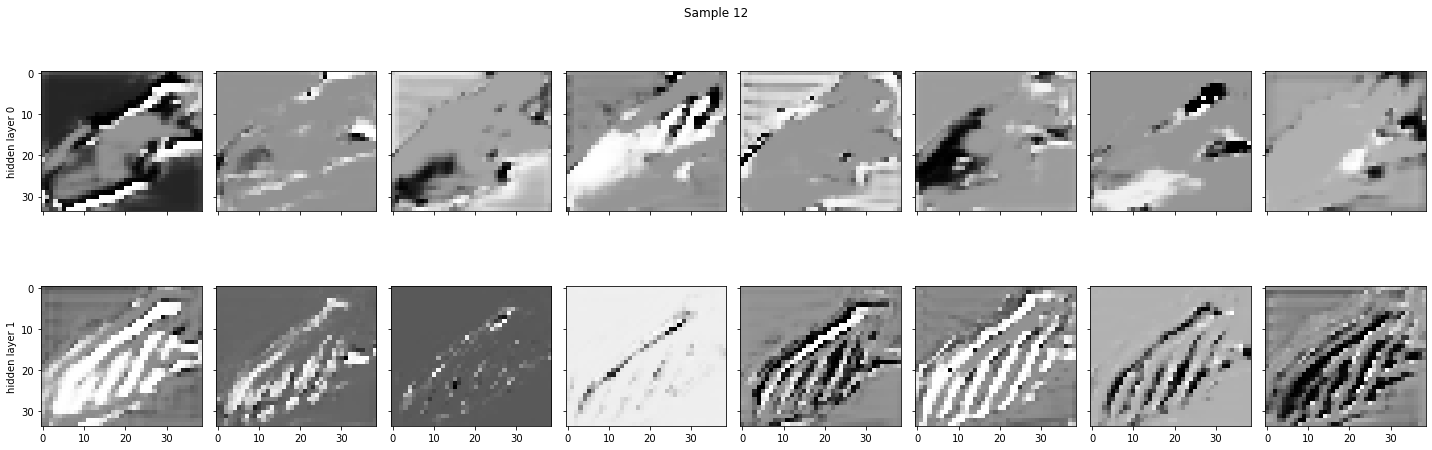

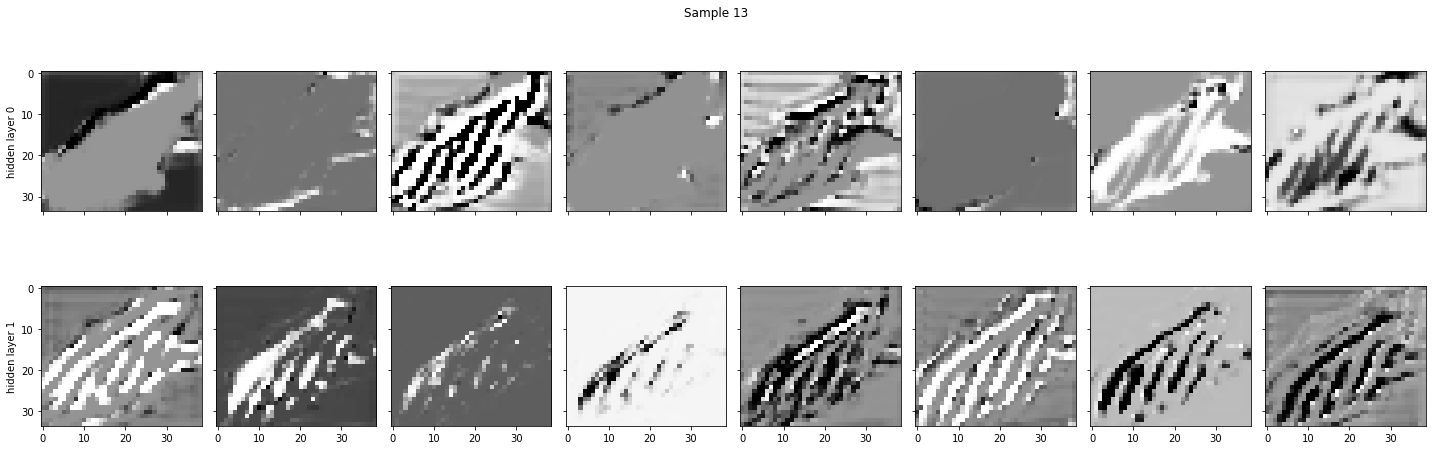

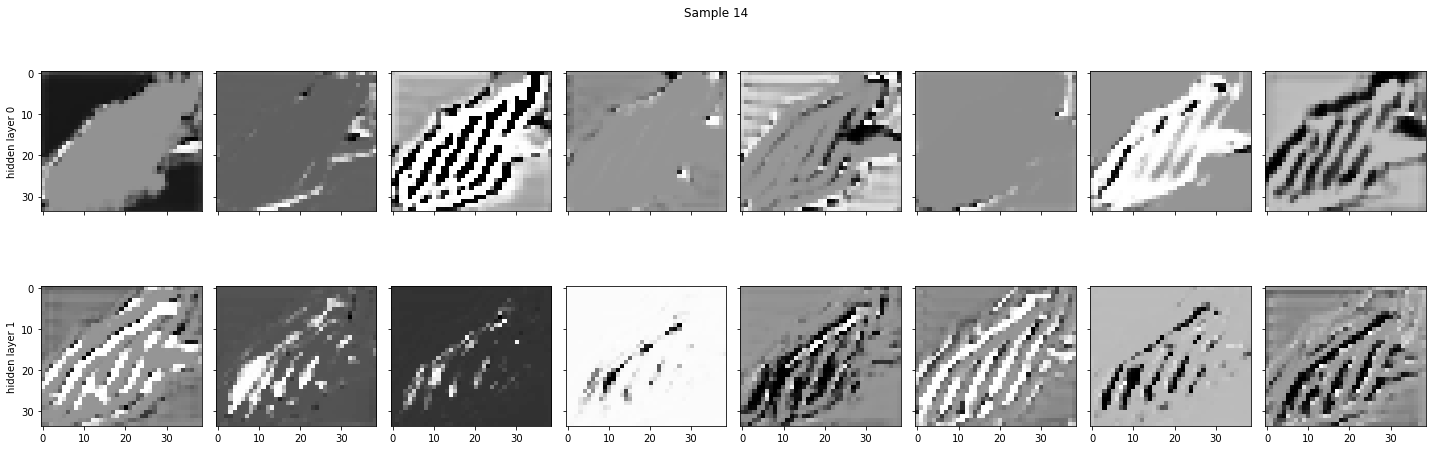

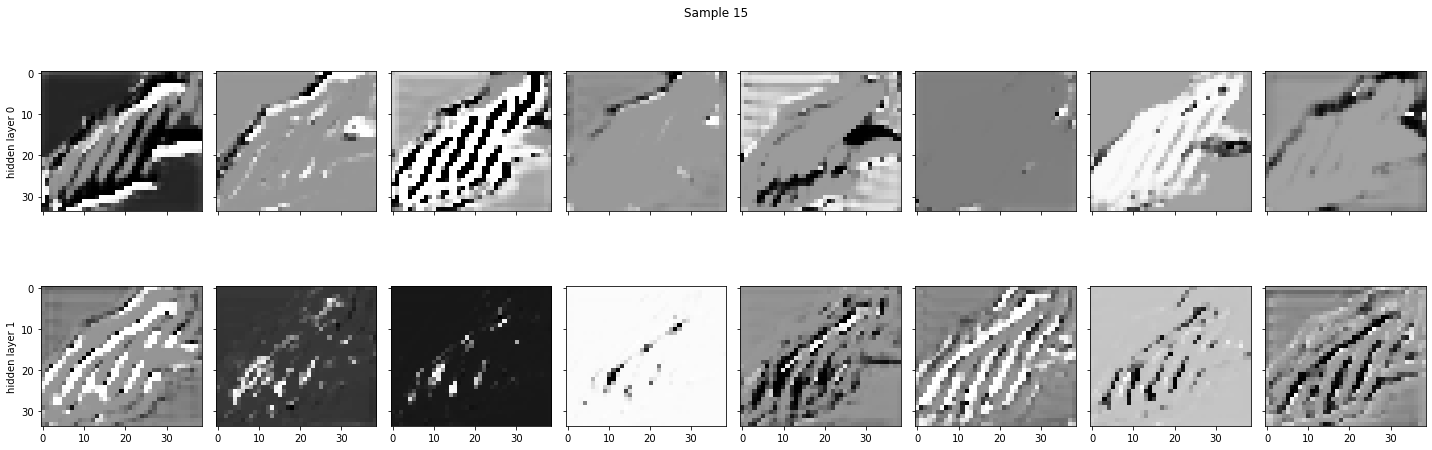

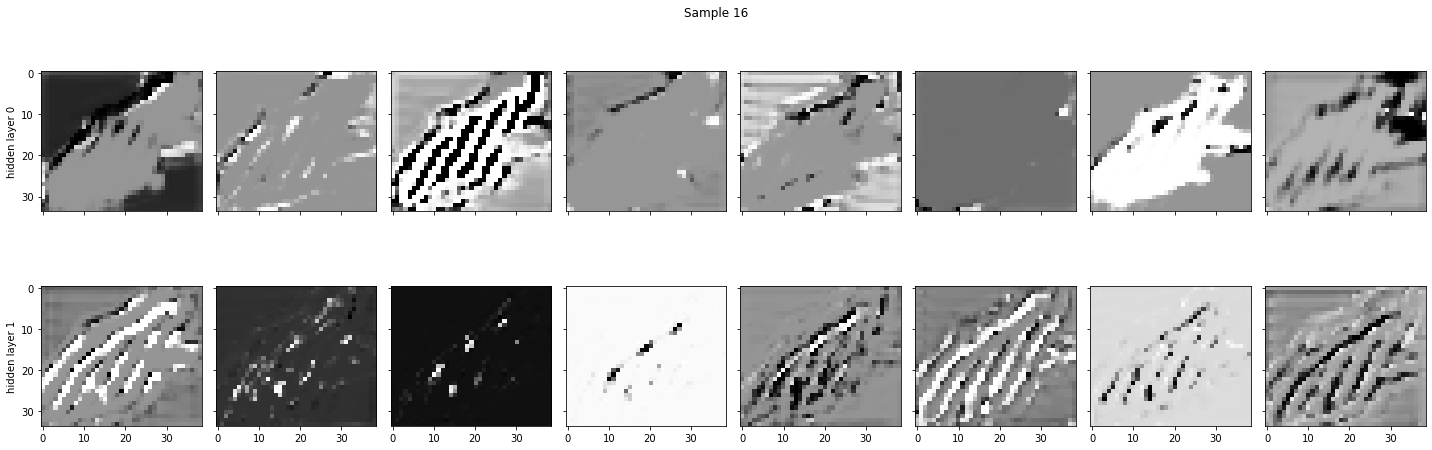

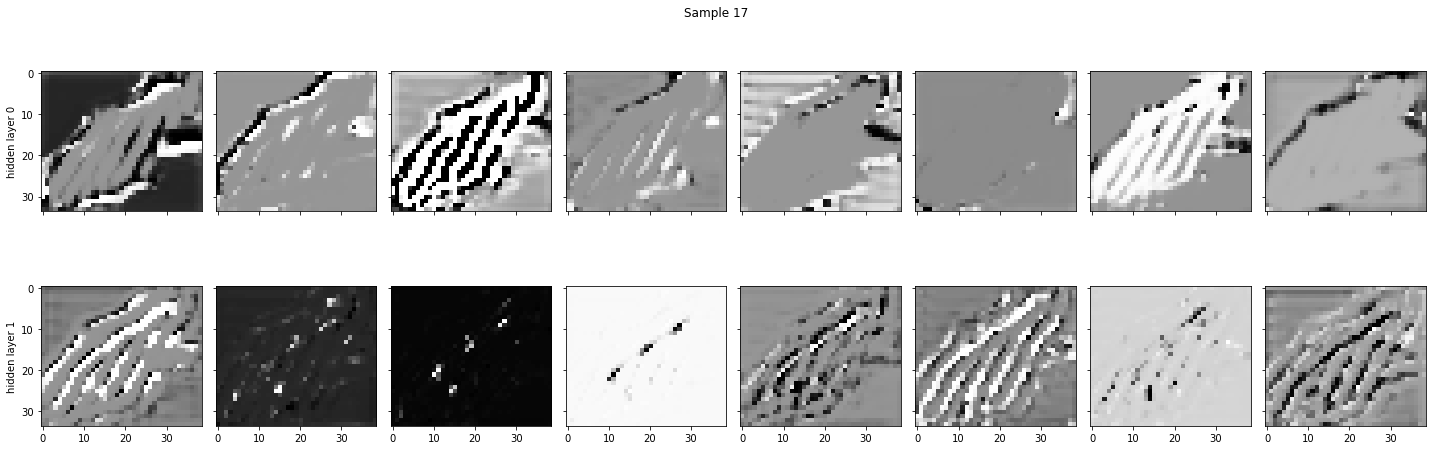

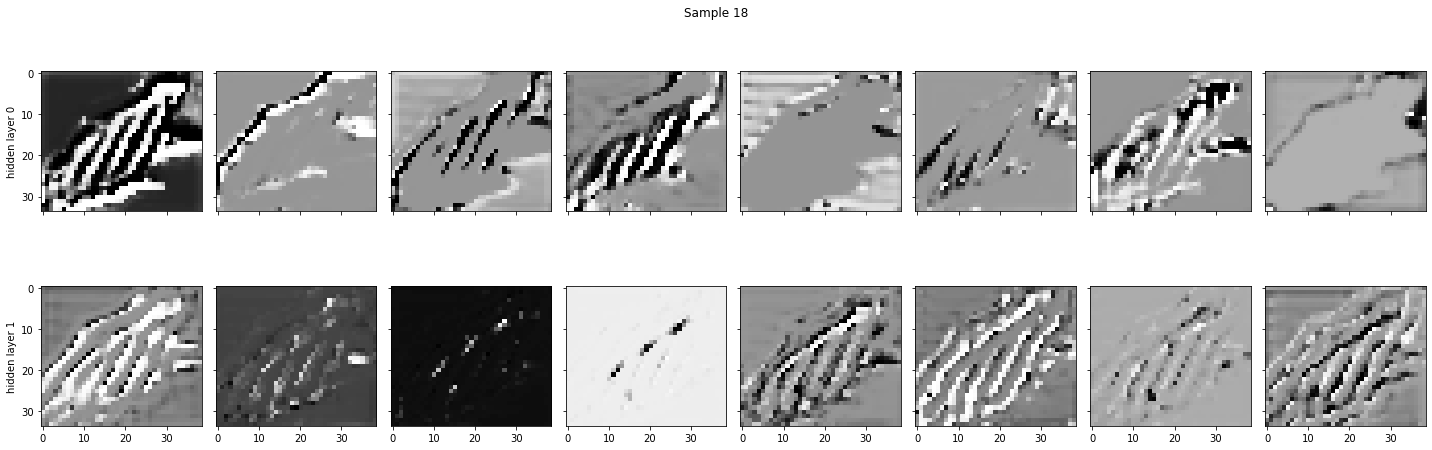

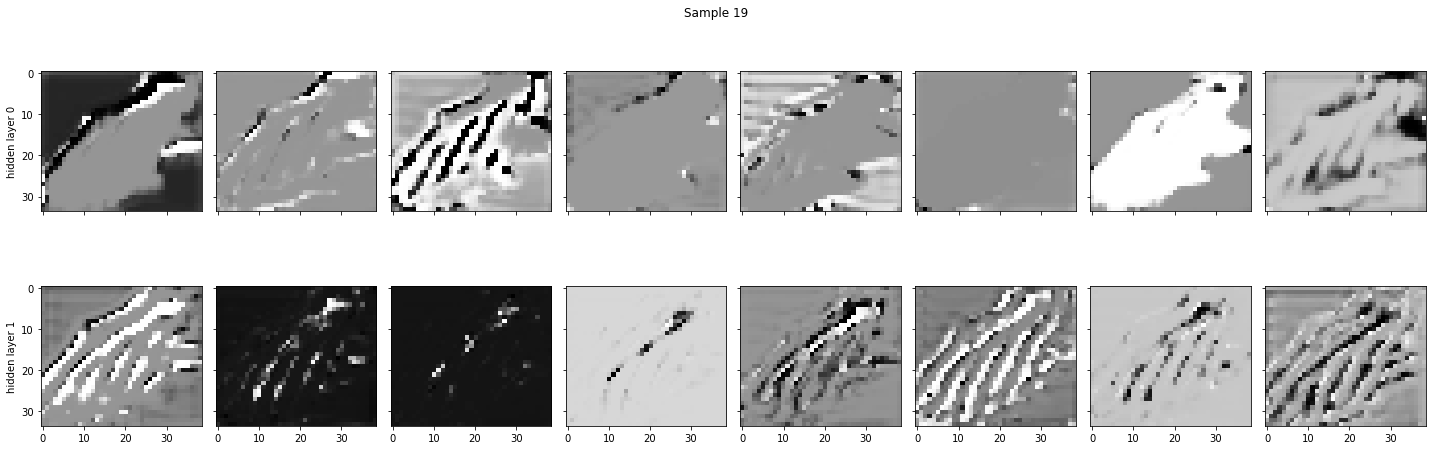

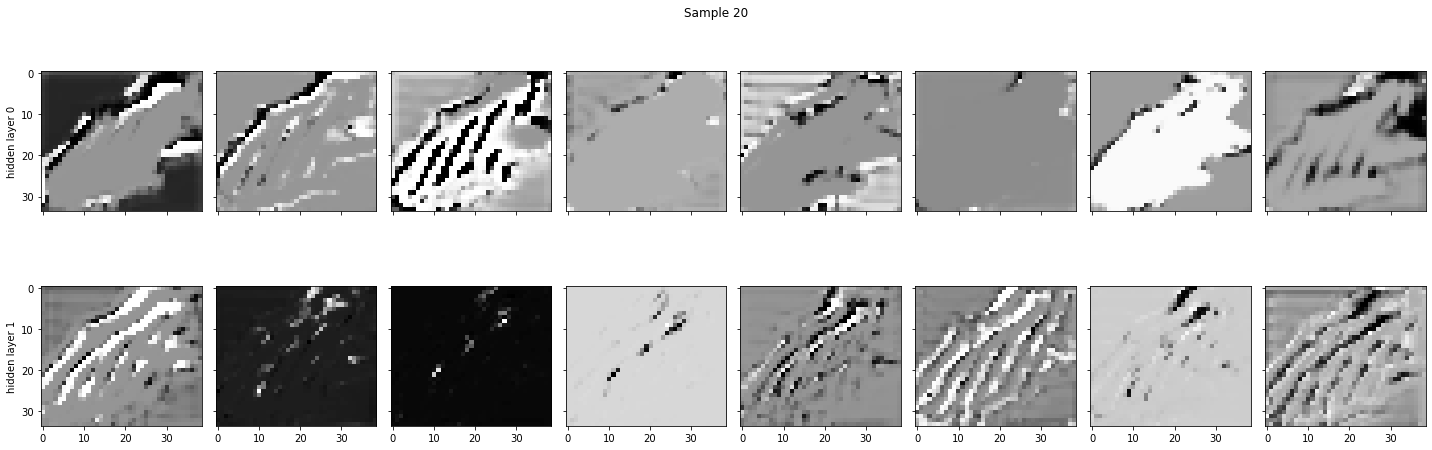

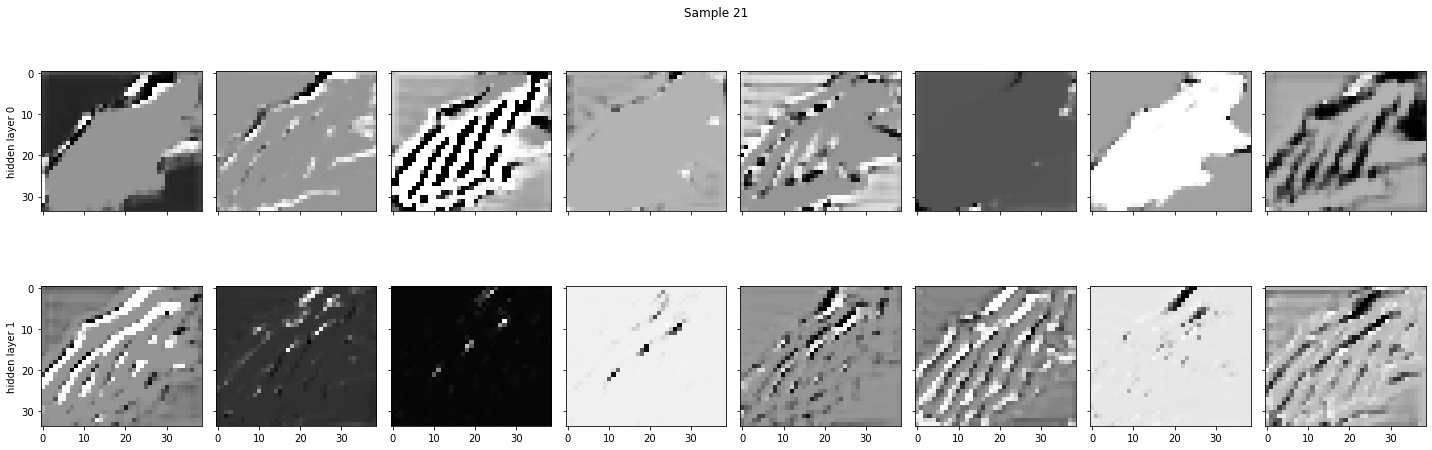

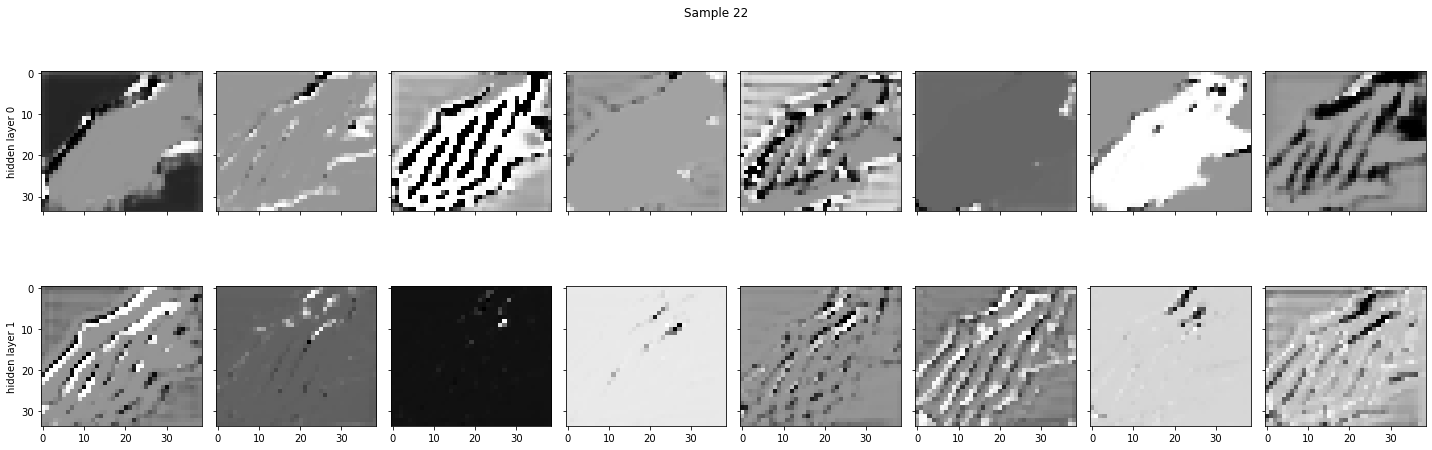

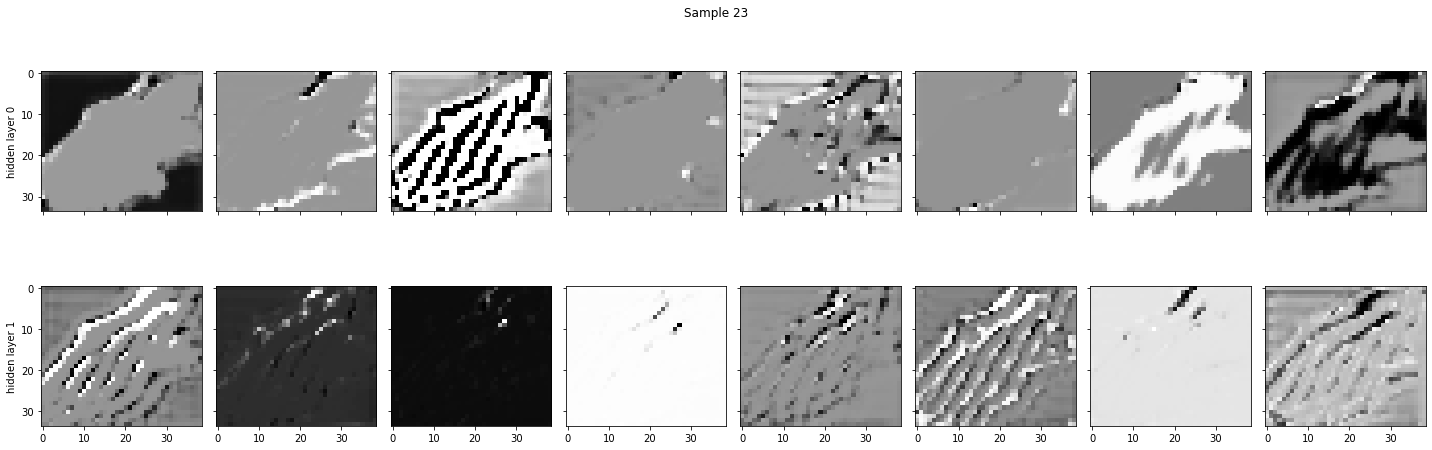

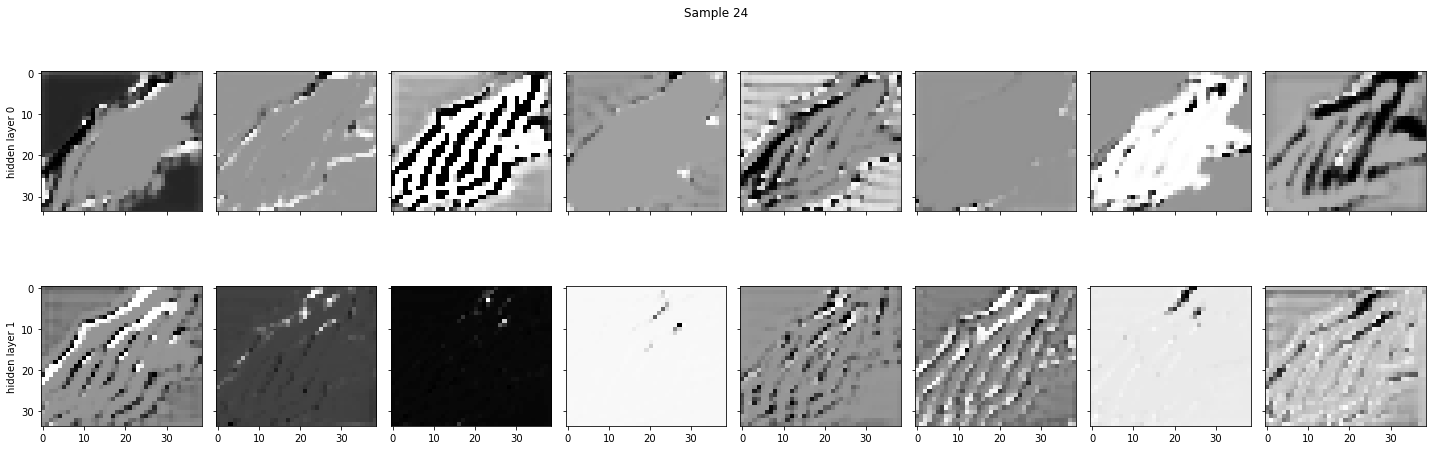

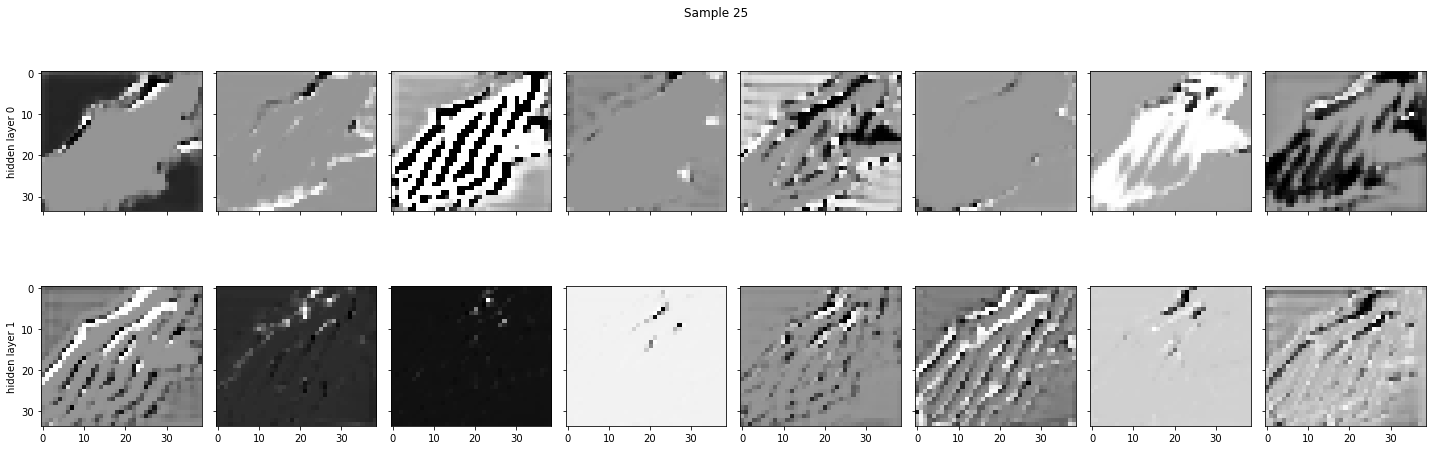

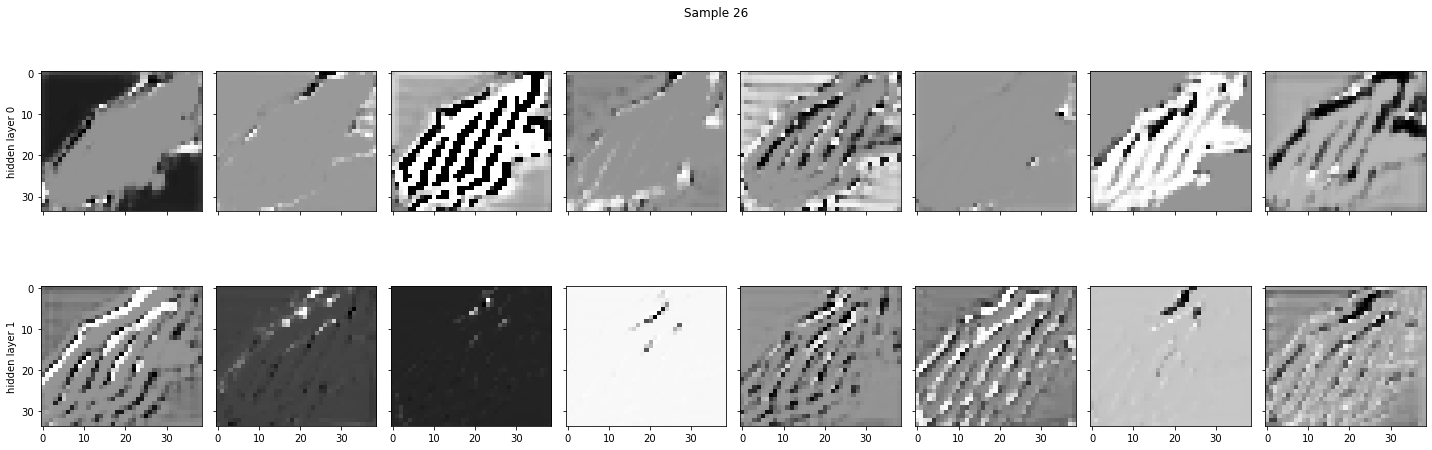

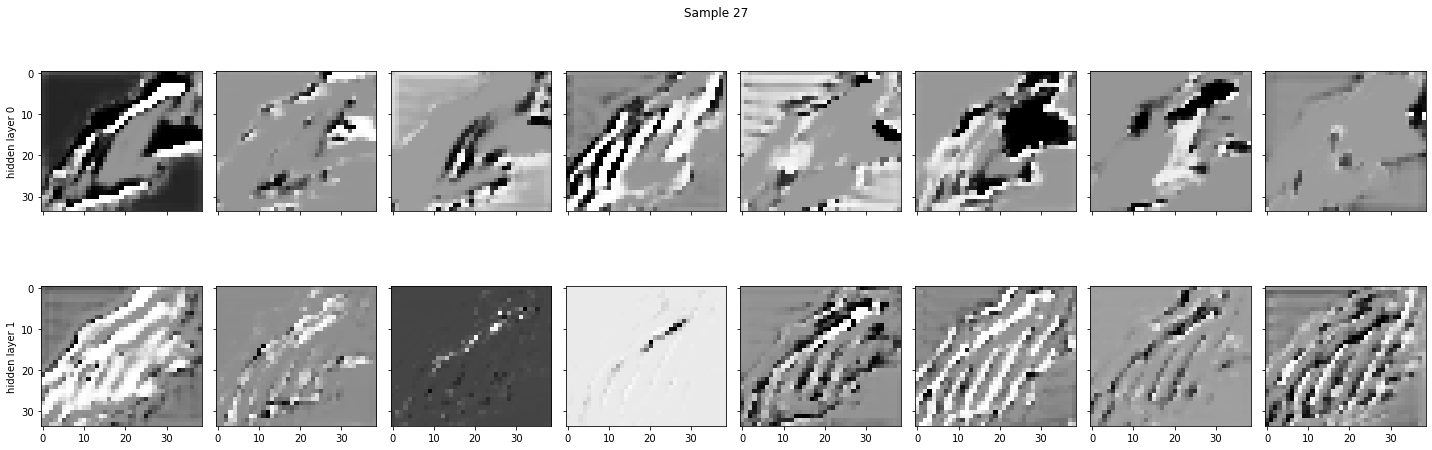

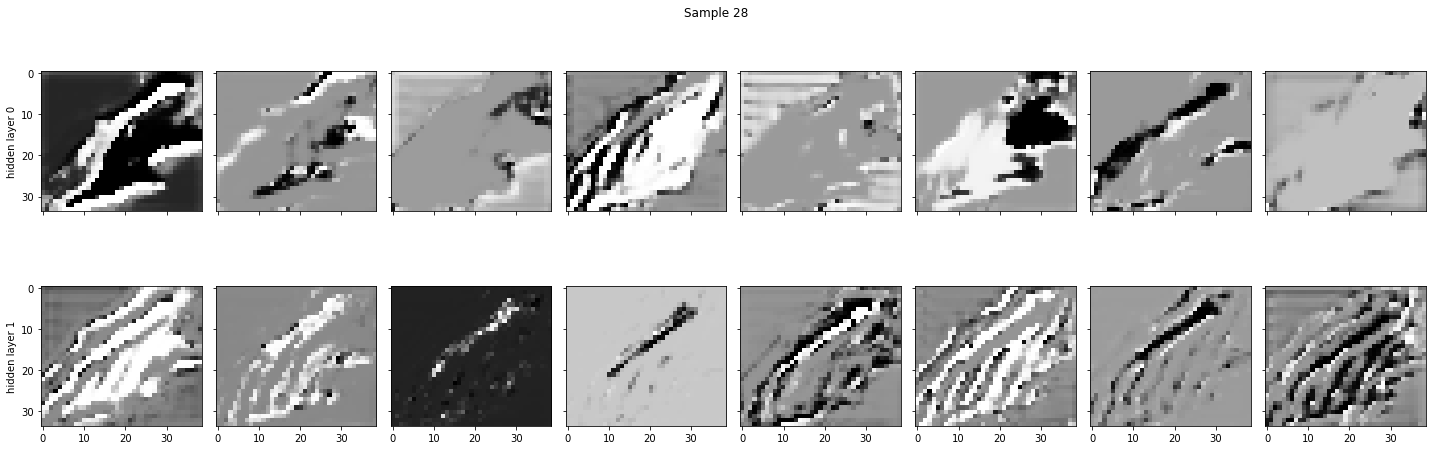

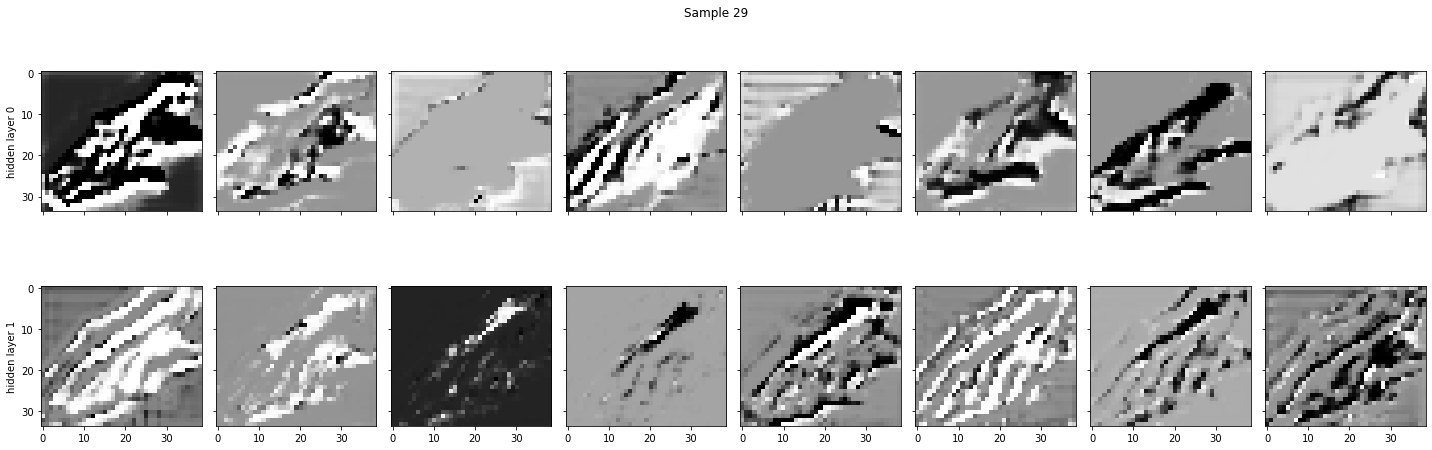

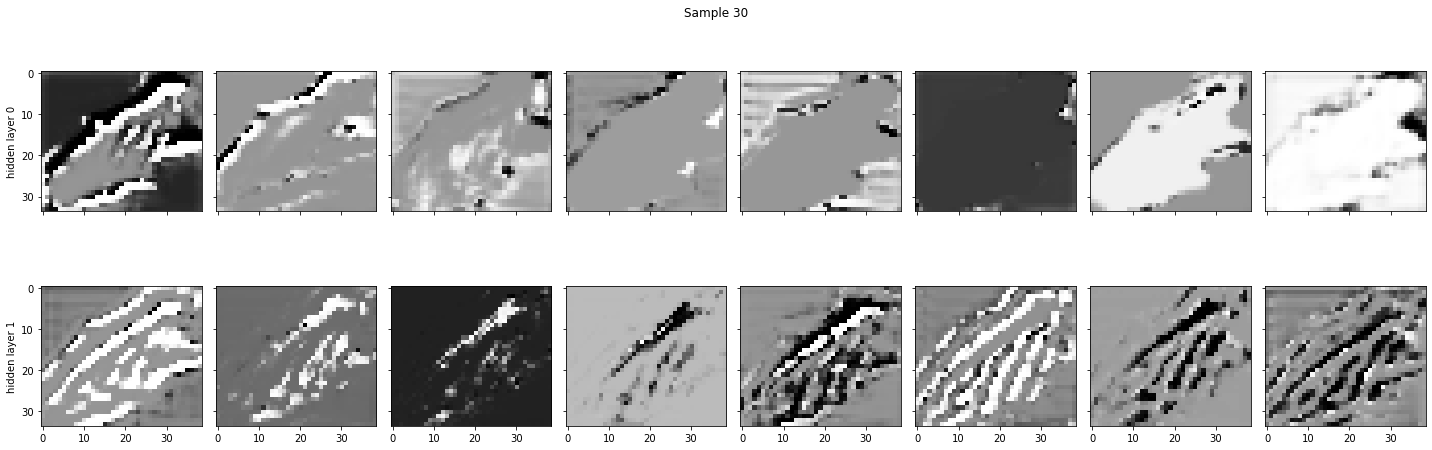

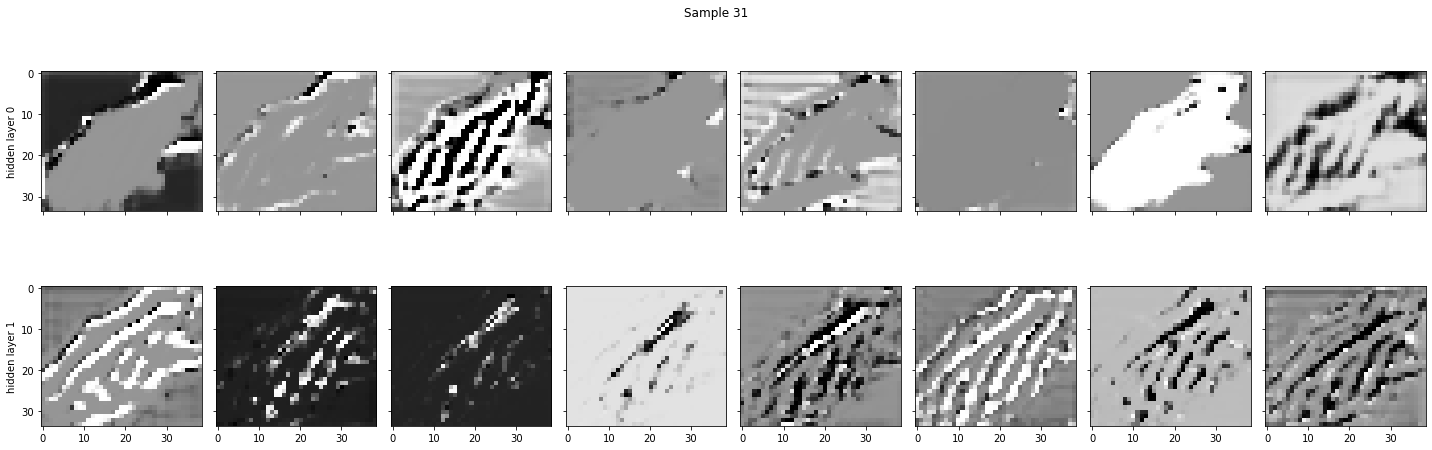

In [20]:
# Visualize conv_lstm hidden layer channels
for sample in range(batch_size):
    visualize.visualize_hidden_channels(convlstm_layers_out, sample, is_convlstm=True)

../../src/visualize.py:32: UserWarning: Tight layout not applied. tight_layout cannot make axes width small enough to accommodate all axes decorations
  plt.tight_layout()


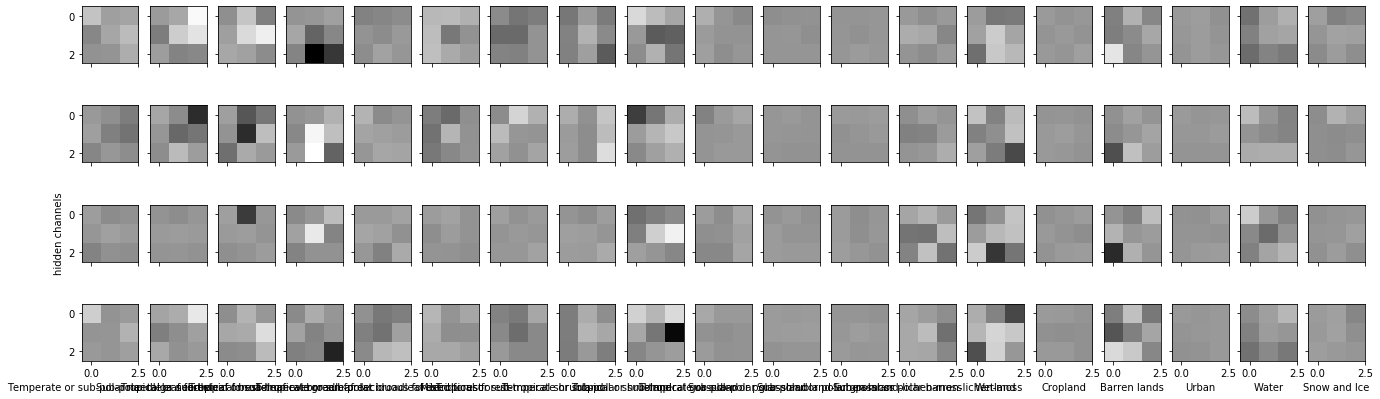

In [21]:
# Visualize conv kernels landcover -> 1st conv-hidden layer
conv_in_layer = model.conv_out[1]
visualize.visualize_kernels(conv_in_layer, landcover_legend, conv_in_layer.weight.shape[0], figsize=(23,7))

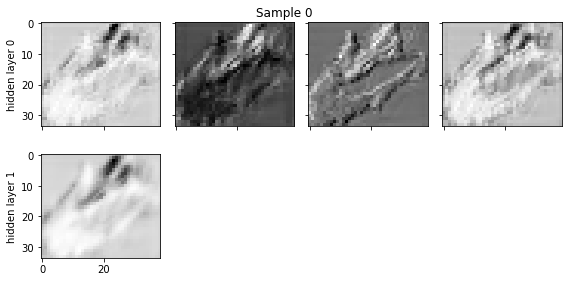

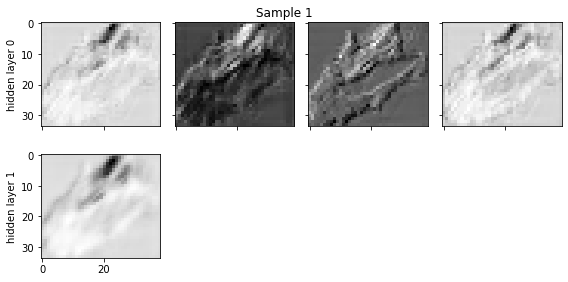

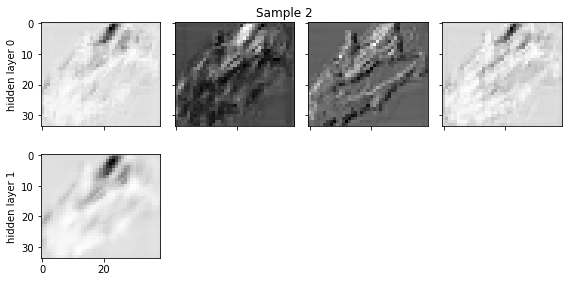

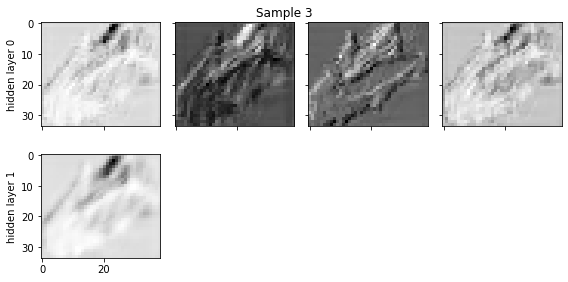

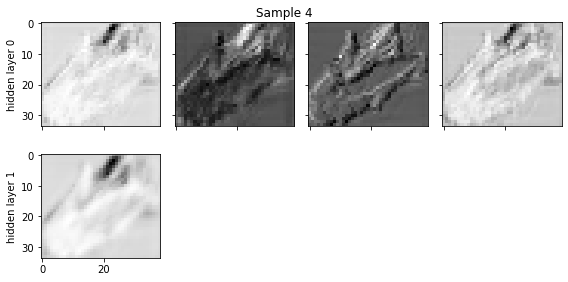

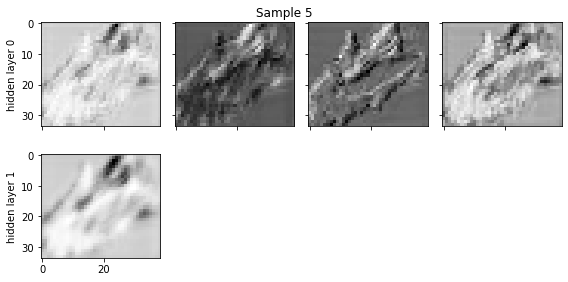

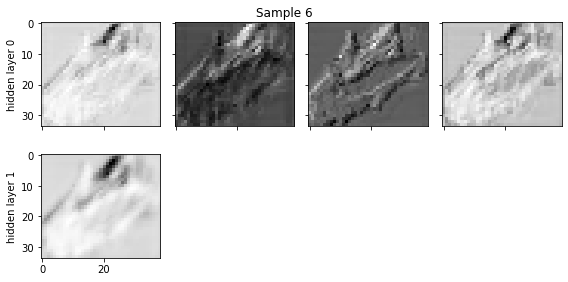

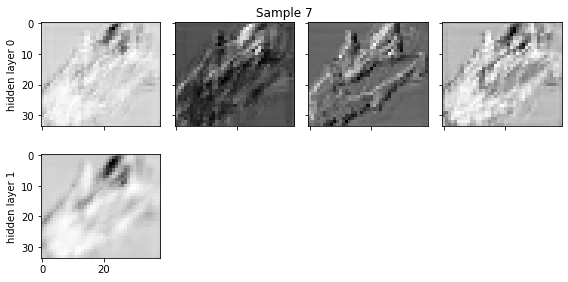

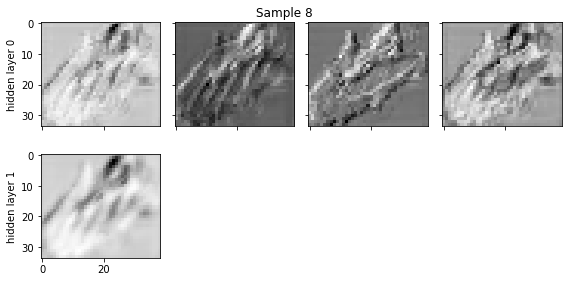

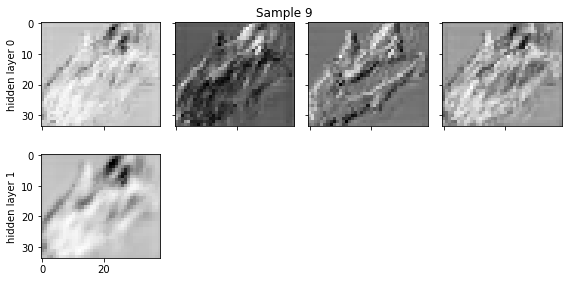

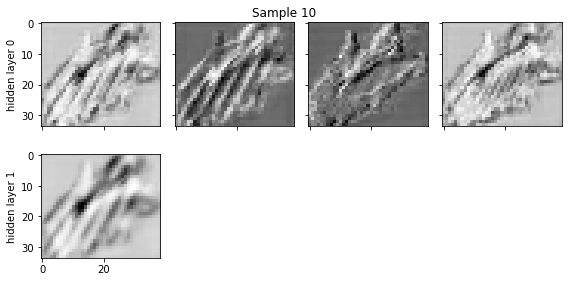

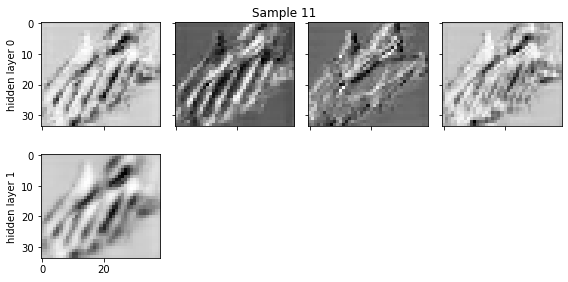

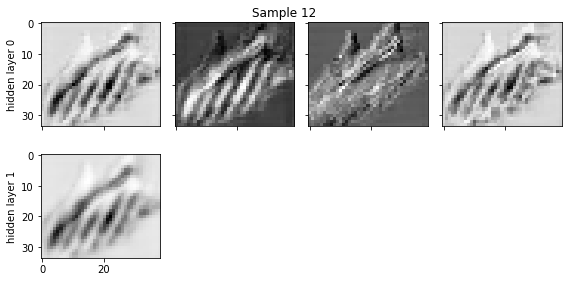

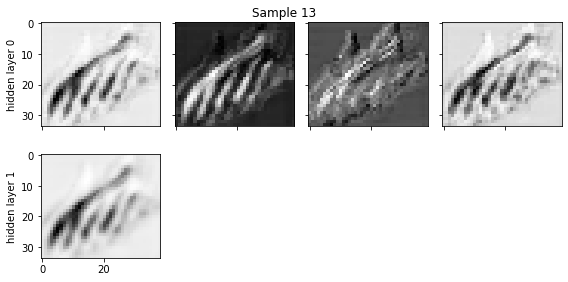

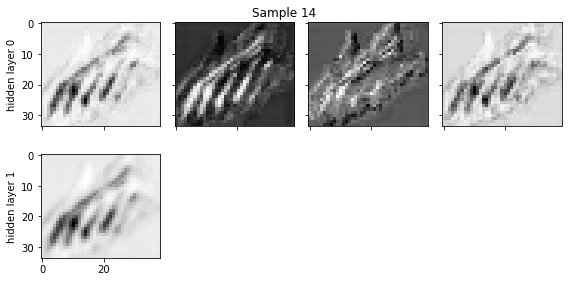

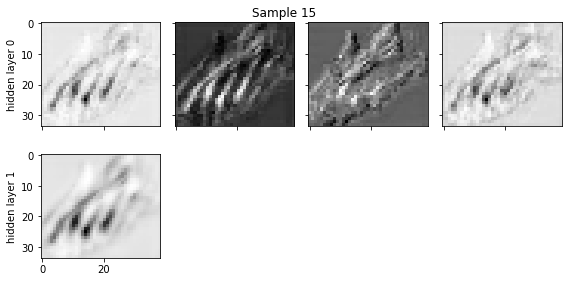

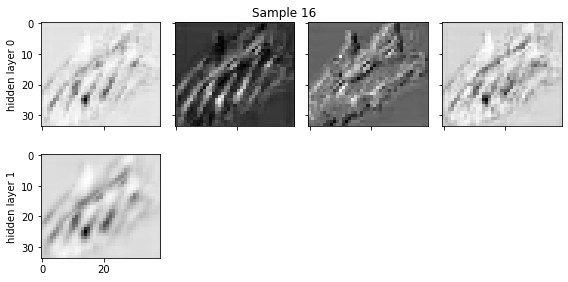

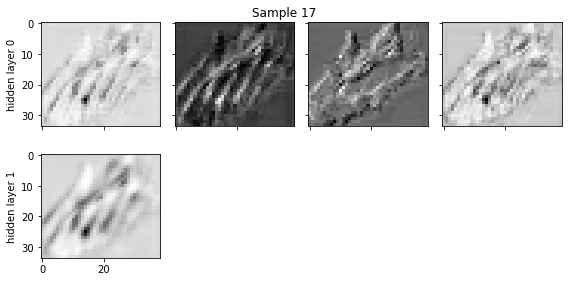

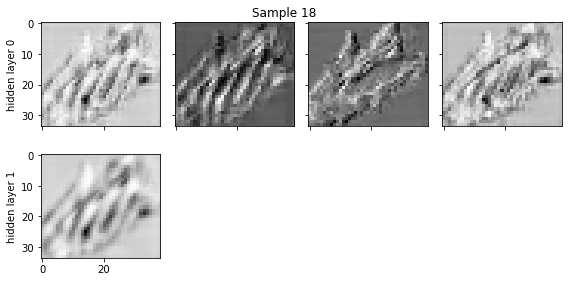

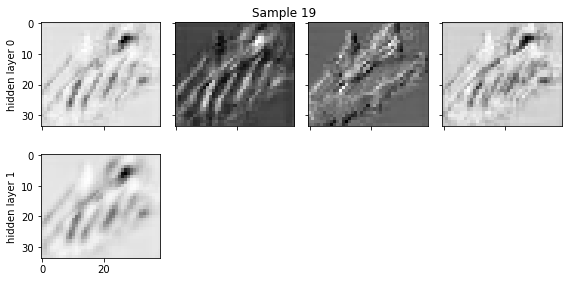

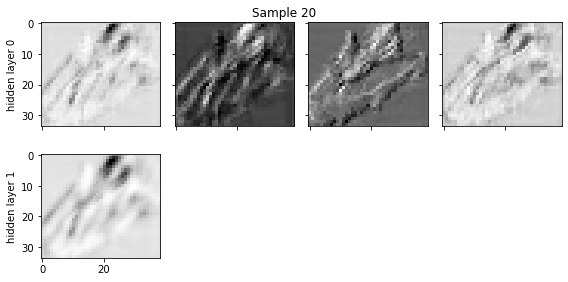

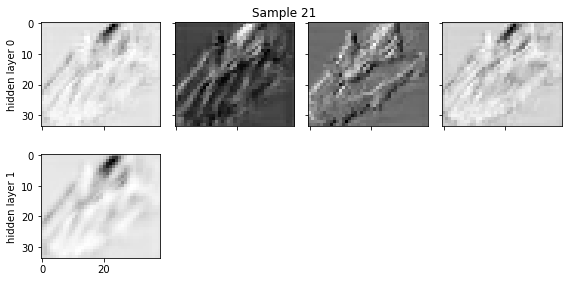

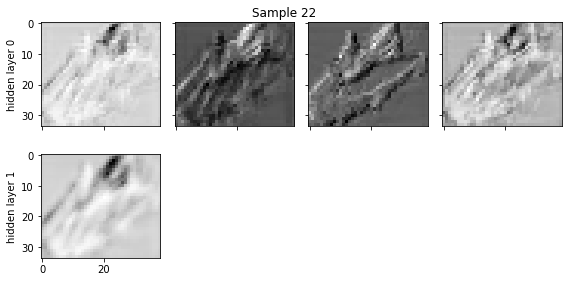

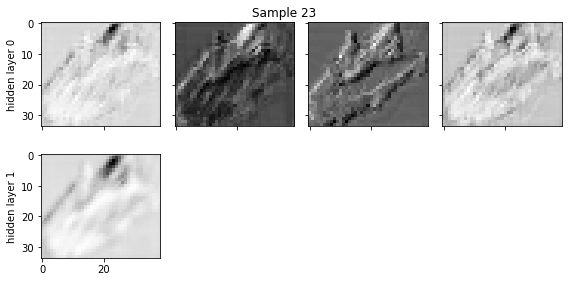

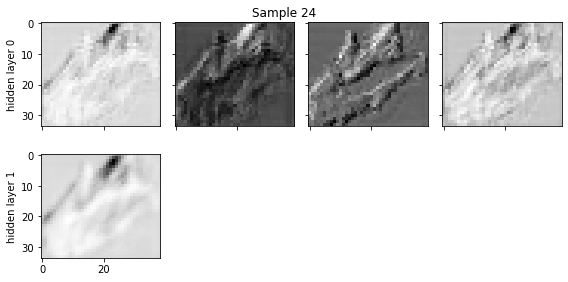

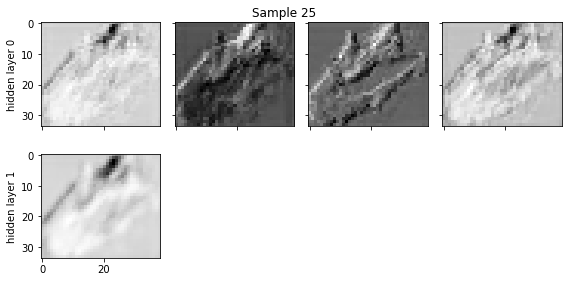

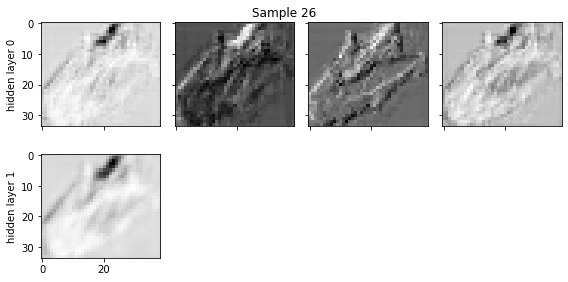

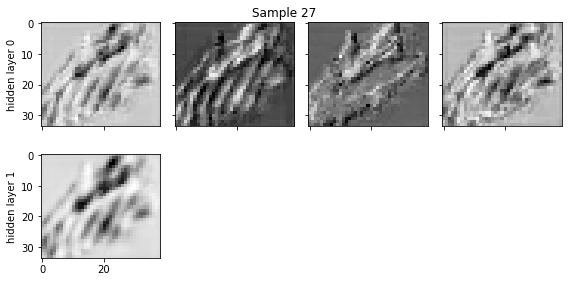

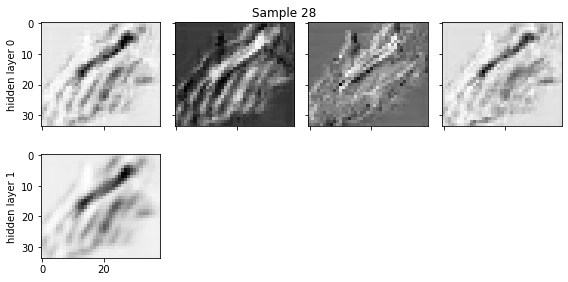

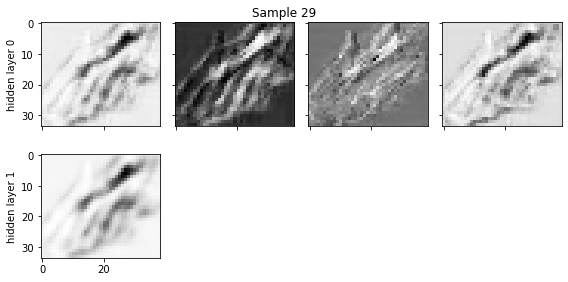

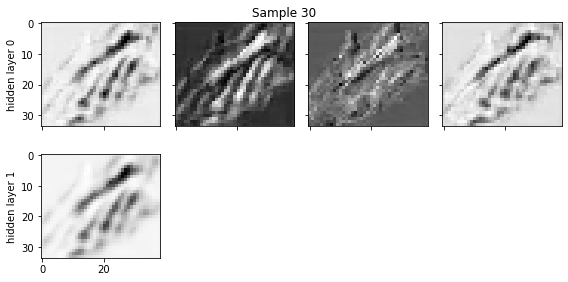

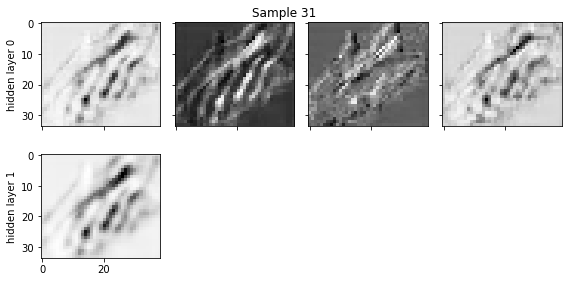

In [22]:
# Visualize conv hidden layers over time
convlstm_out = convlstm_layers_out[-1][:,-1,:,:,:] # last output of last layer
conv_in = torch.cat([convlstm_out, landcover.repeat(convlstm_out.shape[0],1,1,1)], dim=1)

conv_hidden_layers_out = []
conv_hidden_layers_out.append(model.conv_out[1](conv_in))
conv_hidden_layers_out.append(model.conv_out[5](conv_hidden_layers_out[-1]))
for sample in range(batch_size):
    visualize.visualize_hidden_channels(conv_hidden_layers_out, sample, figsize=(8,4))